In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.mlab import griddata

### Fixed Parameters

In [4]:
β = 0.005
μ1 = 1/21 #14 days infectious
μ2 = 1/5 #5 days (14 - 9 days)
σ =1/5 #5 days exposed
ω=1/9 # 9 days until emitted to hospital
ϵ = 0.0001
α = 1/2
pp = 0.7
capT = 10000
γ = 1/(80*365)
Input_H = [1500,1,0,0,0]

# SEIHR with fixed parameters

In [5]:
def gillespieSEIHR(initial, beta, mu1,mu2, sigma, omega,epsilon,alpha, mort, gam,  max_time):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    cuminf = []
    cuminf.append(0)
    events = []
    while times <max_time and (pop[ind][1]+pop[ind][2]+pop[ind][3]>0):
        state = np.zeros(shape= (5,12))
        
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################
        
        
        R_se = beta*(pop[ind][0])*(pop[ind][2] + alpha*pop[ind][3])/N + epsilon*pop[ind][0] 
        state[:,0] = [-1, 1, 0, 0,0]
        
        R_ei = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0,0]
        
        R_ih = omega*pop[ind][2]
        state[:,2] = [0, 0, -1, 1, 0]
        
        R_ir = mort*mu1*pop[ind][2]
        state[:,3] = [0,0,-1,0,1]
        
        R_hr = mort*mu2*pop[ind][3]
        state[:,4] = [0,0,0,-1,1]
#         print('R_ir',  R_ir)
        R_is = (1-mort)*mu1*pop[ind][2]
        state[:,5] = [1,0,-1,0,0]
#         print('R_is', R_is)
        R_hs = (1-mort)*mu2*pop[ind][3]
        state[:,6] = [1,0,0,-1,0]
        
        ########################### natural deaths + births #################################
# #         R_sb = 0.00001
#         R_sb = gam*1500
# #         print('R_sb', R_sb)
#         state[:,7] = [1,0,0,0,0]

#         R_sd = -gam*pop[ind][0]
#         state[:,8] = [-1,0,0,0,0]
# #         print('R_sd', R_sd)
#         R_ed = -gam*pop[ind][1]
#         state[:,9] = [0,-1,0,0,0]
        
#         R_id = -gam*pop[ind][2]
#         state[:,10] = [0,0,-1,0,0]   
        
#         R_hd = -gam*pop[ind][3]
#         state[:,11] = [0,0,0,-1,0]
        
        #####################################################################################
        
#         rate = [R_se, R_ei, R_ih, R_ir, R_hr, R_is, R_hs, R_sb, R_sd, R_ed, R_id, R_hd]
        rate = [R_se, R_ei, R_ih, R_ir, R_hr, R_is, R_hs]

        Rtotal = sum(rate)
        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
#         print(delta_t, Rtotal, np.log(np.random.uniform(0,1)))
        P = np.random.uniform(0,1)*Rtotal
        times =times+ delta_t
        event = np.min(np.where(P<=np.cumsum(rate)))
        events.append(event)
        event_time.append(times)
        pop.append(pop[ind]+state[:,event])
        
        if event == 1:
            cuminf.append(1 )
        else:
            cuminf.append(0)
        ind=ind+1
        N = sum(pop[ind][:5])
#         print(pop[ind][:5], N)
#         print(event_time)
    return event_time, np.array(pop), events

## ODEs

In [6]:
def dSEIHR_dt(X, tt ):
#     print(sum(X[:3]))
    return [-β*X[0]*(X[2]+α*X[3])/sum(X[:3]) - ϵ*X[0] + (1-pp)*(μ1*X[2] + μ2*X[3]), 
            β*X[0]*(X[2]+α*X[3])/sum(X[:3]) + ϵ*X[0]- σ*X[1] ,
            σ*X[1] - (μ1+ω)*X[2],
            ω*X[2]-μ2*X[3],
            pp*(μ1*X[2]+μ2*X[3])]

ts = np.linspace(0, capT, 1000)
Nn = sum(Input_H)
P_seihr = odeint(dSEIHR_dt, Input_H, ts)

# Plots

In [7]:
Gh = gillespieSEIHR(Input_H, β, μ1, μ2, σ, ω, ϵ, α,pp, γ, capT)
SEIHRt = Gh[0]
SEIHRs = Gh[1][:,0]
SEIHRe = Gh[1][:,1]
SEIHRi = Gh[1][:,2]
SEIHRh = Gh[1][:,3]
SEIHRr = Gh[1][:,4]

In [ ]:
manhe = []
manht = []
manhh = []
manhi = []
for ind, x in enumerate(SEIHRt):
    if ind<len(SEIHRt)-1:
        manhe.append((SEIHRe[ind], SEIHRe[ind]))
        manhh.append((SEIHRh[ind], SEIHRh[ind]))
        manhi.append((SEIHRi[ind], SEIHRi[ind]))
        manht.append((SEIHRt[ind], SEIHRt[ind+1]))
manhe = np.array(manhe).flatten()
manht = np.array(manht).flatten()
manhh = np.array(manhh).flatten()
manhi = np.array(manhi).flatten()

In [ ]:
plt.figure(figsize = (20,8))
# plt.plot(SEIHRt, SEIHRr/Nn,c='blue', label = 'removed')
plt.plot(manht, manhe/Nn,c='orange', label = 'exposed')
plt.plot(manht, manhh/Nn,c='magenta', label = 'hosptial')

# plt.plot(SEIHRt,SEIHRs/Nn, c='yellowgreen',label = 'susceptible')
plt.plot(manht,manhi/Nn,c= 'r', label = 'infected')
plt.legend(fontsize = 20)

## Multiple simulations

In [10]:
Time = []
Inf = []
Exp = []
Hos = []
Cum = []
Num_sim = 10000
for i in range(Num_sim):
    Gh_adj = gillespieSEIHR(Input_H, β, μ1, μ2, σ, ω, ϵ, α,pp, γ, capT)
    SEIHRt_adj = Gh_adj[0]
    SEIHRs_adj = Gh_adj[1][:,0]
    SEIHRe_adj = Gh_adj[1][:,1]
    SEIHRi_adj = Gh_adj[1][:,2]
    SEIHRh_adj = Gh_adj[1][:,3]
    SEIHRr_adj = Gh_adj[1][:,4]
    manhe = []
    manht = []
    manhh = []
    manhi = []
    cum_inf = []
    for ind, x in enumerate(SEIHRt_adj):
        if ind<len(SEIHRt_adj)-1:
            manhe.append((SEIHRe_adj[ind], SEIHRe_adj[ind]))
            manhh.append((SEIHRh_adj[ind], SEIHRh_adj[ind]))
            manhi.append((SEIHRi_adj[ind], SEIHRi_adj[ind]))
            manht.append((SEIHRt_adj[ind], SEIHRt_adj[ind+1]))
            cum_inf.append((np.cumsum(np.array(Gh_adj[2]) == 1)[ind], np.cumsum(np.array(Gh_adj[2]) == 1)[ind])) 
    Time.append(np.array(manht).flatten())
    Inf.append(np.array(manhi).flatten())
    Exp.append(np.array(manhe).flatten())
    Hos.append(np.array(manhh).flatten())
    Cum.append(np.array(cum_inf).flatten())

In [11]:
max_time = []
num_inf = []
for k in range(Num_sim):
    max_time.append(max(Time[k]))
    num_inf.append(Cum[k][-1])
    
totalT = math.ceil(max(max_time))
inter_t = np.arange(0, totalT , 0.5)

In [12]:
np.mean(num_inf)

9.9003

Text(0,0.5,'Final Size')

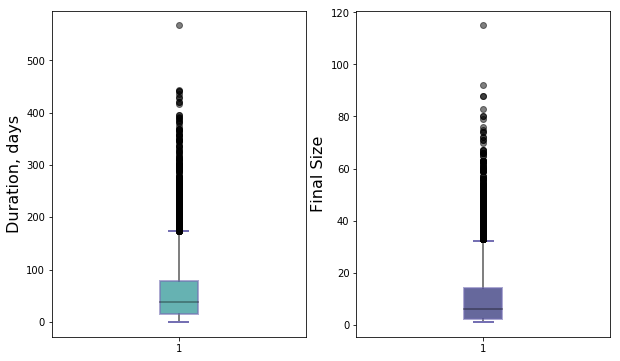

In [13]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(121)
bp = ax.boxplot(max_time, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = 'teal' , alpha = 0.6)

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='grey', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='black', alpha = 0.3, linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='yellow', alpha=0.5)

plt.ylabel('Duration, days', fontsize =16)

ax = fig.add_subplot(122)
bp = ax.boxplot(num_inf, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#00035b' , alpha = 0.6)

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='grey', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='black', alpha = 0.3, linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='yellow', alpha=0.5)

plt.ylabel('Final Size', fontsize = 16)

Text(0,0.5,'Duration')

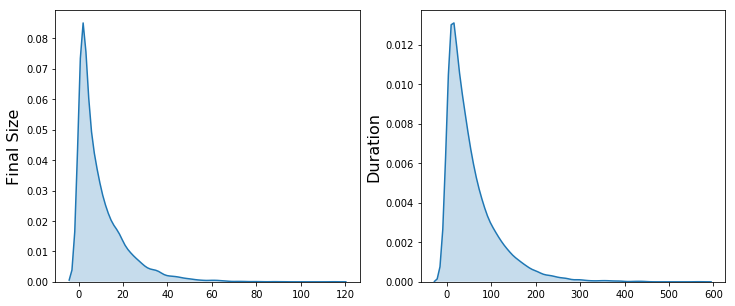

In [14]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
sns.kdeplot(num_inf, shade = True)
plt.ylabel('Final Size', fontsize = 16)
plt.subplot(1,2,2)
sns.kdeplot(max_time, shade = True)
plt.ylabel('Duration', fontsize =16)


/home/emma/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


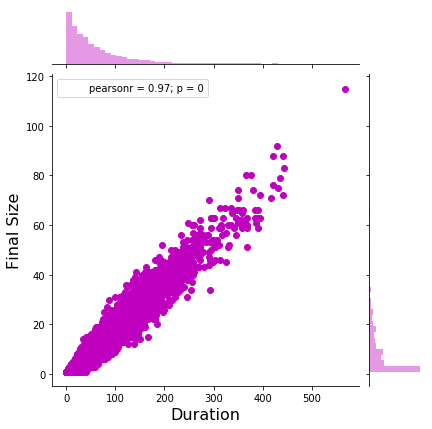

In [15]:
d= {'duration': max_time, 'finalsize': num_inf}
df = pd.DataFrame(data = d)
g = sns.jointplot(x="duration", y="finalsize", data=df[df['duration']<600], color = 'm')
# g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
# g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("Duration", "Final Size", fontsize = 16);

In [16]:
inter_i = []
inter_e = []
inter_h = []
inter_cum = []
for l in range(Num_sim):
    inter_i.append(np.interp(inter_t, Time[l], Inf[l], right = 0))
    inter_e.append(np.interp(inter_t, Time[l], Exp[l], right = 0))
    inter_h.append(np.interp(inter_t, Time[l], Hos[l], right = 0))
    inter_cum.append(np.interp(inter_t, Time[l], Cum[l]))

Text(0.5,1,'Cumulative Infections')

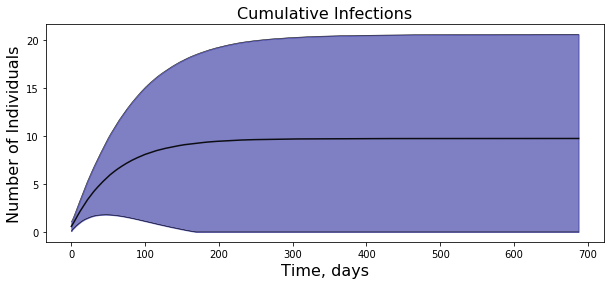

In [17]:
plt.figure(figsize = (10,4))
# plt.subplot(1,3,1)
plt.plot(inter_t, np.mean(inter_cum, axis = 0),'-', color ='k', alpha = 0.9)
plt.plot(inter_t, (np.mean(inter_cum, axis = 0)+np.std(inter_cum, axis = 0)), color ='k', lw=0.5)
plt.plot(inter_t, np.maximum((np.mean(inter_cum, axis = 0)-np.std(inter_cum, axis = 0)),0),color ='k', lw=0.5)
plt.fill_between(inter_t, (np.mean(inter_cum, axis = 0)+np.std(inter_cum, axis = 0)), np.maximum((np.mean(inter_cum, axis = 0)-np.std(inter_cum, axis = 0)),0), 1, alpha=0.5, color = 'darkblue')
# plt.ylim([0,20])
plt.ylabel('Number of Individuals', fontsize = 16)
plt.xlabel('Time, days', fontsize = 16)
plt.title('Cumulative Infections', fontsize = 16)

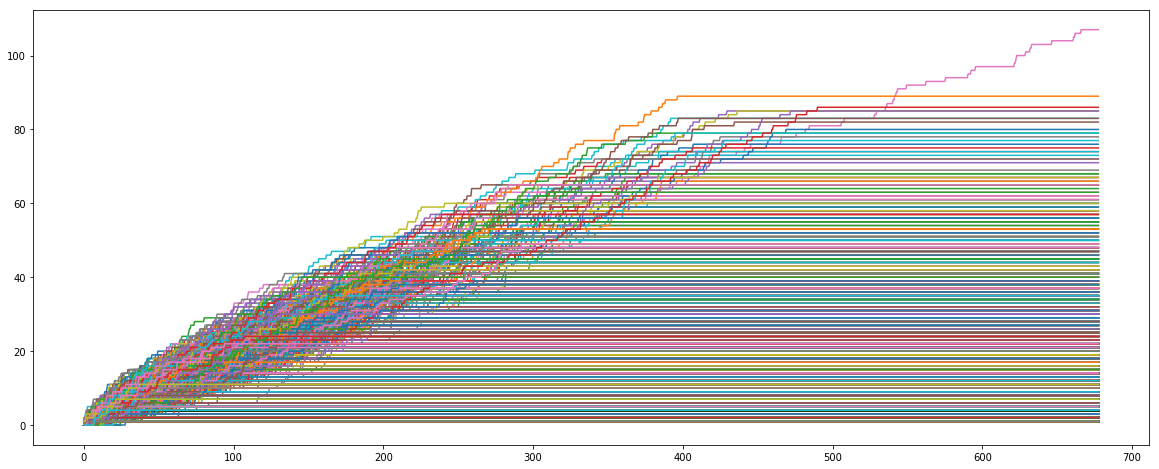

In [226]:
fig = plt.figure(figsize = (20,8))
for z in range(Num_sim):
    plt.plot(inter_t, inter_cum[z])
#     plt.subplot(1,3,1)
#     plt.plot(inter_t, inter_e[z]/Nn)
#     plt.title('Exposed')
#     plt.subplot(1,3,2)
#     plt.plot(inter_t, inter_i[z]/Nn)
#     plt.title('Infected')
#     plt.subplot(1,3,3)
#     plt.plot(inter_t, inter_h[z]/Nn)
#     plt.title('Hospitalized')

Text(0.5,1,'Hosptial')

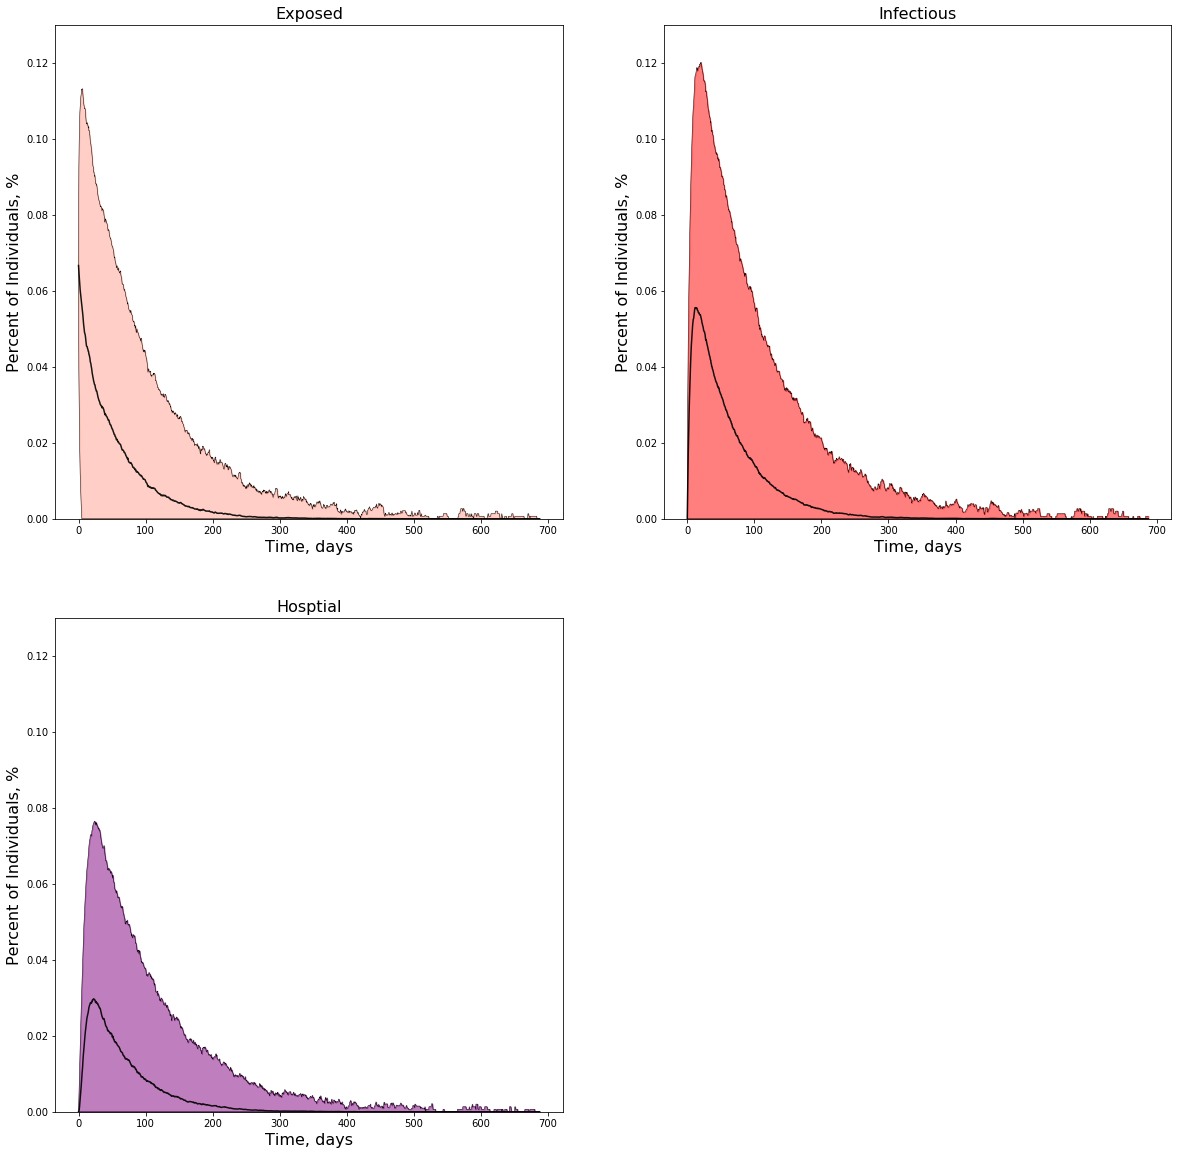

In [27]:
plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(inter_t, 100*np.mean(inter_e, axis = 0)/Nn,'-', color ='k', alpha = 0.9)
plt.plot(inter_t, 100*(np.mean(inter_e, axis = 0)+np.std(inter_e, axis = 0))/Nn, color ='k', lw=0.5)
# plt.plot(inter_t, 100*inter_e[5]/Nn, '--', color = 'grey')
plt.plot(inter_t, 100*np.maximum((np.mean(inter_e, axis = 0)-np.std(inter_e, axis = 0))/Nn,0),color ='k', lw=0.5)
plt.fill_between(inter_t,  100*(np.mean(inter_e, axis = 0)+np.std(inter_e, axis = 0))/Nn, 100*np.maximum((np.mean(inter_e, axis = 0)-np.std(inter_e, axis = 0))/Nn,0), 1, alpha=0.3, color = 'tomato')
plt.ylim([0,0.13])
plt.ylabel('Percent of Individuals, %', fontsize = 16)
plt.xlabel('Time, days', fontsize = 16)
plt.title('Exposed', fontsize = 16)

plt.subplot(2,2,2)
plt.plot(inter_t, 100*np.mean(inter_i, axis = 0)/Nn,'-', color ='k', alpha = 0.9)
plt.plot(inter_t, 100*(np.mean(inter_i, axis = 0)+np.std(inter_i, axis = 0))/Nn, color ='k', lw=0.5)
plt.plot(inter_t, 100*np.maximum((np.mean(inter_i, axis = 0)-np.std(inter_i, axis = 0))/Nn,0),color ='k', lw=0.5)
plt.fill_between(inter_t,  100*(np.mean(inter_i, axis = 0)+np.std(inter_i, axis = 0))/Nn, 100*np.maximum((np.mean(inter_i, axis = 0)-np.std(inter_i, axis = 0))/Nn,0), 1, alpha=0.5, color = 'red')
plt.ylim([0,0.13])
plt.ylabel('Percent of Individuals, %', fontsize = 16)
plt.xlabel('Time, days', fontsize = 16)
plt.title('Infectious', fontsize = 16)

plt.subplot(2,2,3)
plt.plot(inter_t, 100*np.mean(inter_h, axis = 0)/Nn,'-', color ='k', alpha = 0.9)
plt.plot(inter_t, 100*(np.mean(inter_h, axis = 0)+np.std(inter_h, axis = 0))/Nn, color ='k', lw=0.5)
plt.plot(inter_t, 100*np.maximum((np.mean(inter_h, axis = 0)-np.std(inter_h, axis = 0))/Nn,0),color ='k', lw=0.5)
plt.fill_between(inter_t,  100*(np.mean(inter_h, axis = 0)+np.std(inter_h, axis = 0))/Nn, 100*np.maximum((np.mean(inter_h, axis = 0)-np.std(inter_h, axis = 0))/Nn,0), 1, alpha=0.5, color = 'purple')
plt.ylim([0,0.13])
plt.ylabel('Percent of Individuals, %', fontsize = 16)
plt.xlabel('Time, days', fontsize = 16)
plt.title('Hosptial', fontsize = 16)

## Changing $\beta$ and $\varepsilon$

In [122]:
import time

betas = np.linspace(0,0.01, 100)
eps = np.linspace(0,0.005, 100)


In [ ]:
final = np.zeros(shape = (100,100))
duration = np.zeros(shape = (100,100))

for k in range(100):
    for y in range(100):
        start = time.time()
        B = betas[k]
        E = eps[y]
        Time = []
        Cum = []
        Num_sim = 100
        for i in range(Num_sim):
            Gh_adj = gillespieSEIHR(Input_H, β, μ1, μ2, σ, ω, ϵ, α,pp, γ, capT)
            SEIHRt_adj = Gh_adj[0]
#             cum_inf = []
            manht = []
            for ind, x in enumerate(SEIHRt_adj):
                if ind<len(SEIHRt_adj)-1:
                    manht.append((SEIHRt_adj[ind], SEIHRt_adj[ind+1]))
#                     cum_inf.append((np.cumsum(np.array(Gh_adj[2]) == 1)[ind], np.cumsum(np.array(Gh_adj[2]) == 1)[ind])) 
            Time.append(np.array(manht).flatten())
            Cum.append(sum(np.array(Gh_adj[2])==1))
#             Cum.append(np.array(cum_inf).flatten())
        total_time = []
#         num_inf = []
        for j in range(Num_sim):
            total_time.append(max(Time[j]))
#             num_inf.append(np)
        print(np.mean(Cum))
        final[k,y] = np.mean(Cum)
#         final[k,y] = np.mean(num_inf)
        duration[k,y] = np.mean(total_time)
        print("k,y, time ", k,y, time.time() - start)

8.64
k,y, time  0 0 0.15496015548706055
9.0
k,y, time  0 1 0.16150808334350586
11.04
k,y, time  0 2 0.2018890380859375
11.16
k,y, time  0 3 0.2215440273284912
10.58
k,y, time  0 4 0.19275617599487305
9.22
k,y, time  0 5 0.16515278816223145
12.18
k,y, time  0 6 0.2184443473815918
9.75
k,y, time  0 7 0.1807994842529297
10.91
k,y, time  0 8 0.2007923126220703
9.33
k,y, time  0 9 0.1631462574005127
10.25
k,y, time  0 10 0.18199396133422852
10.0
k,y, time  0 11 0.17063593864440918
9.18
k,y, time  0 12 0.17157721519470215
11.58
k,y, time  0 13 0.20139002799987793
9.12
k,y, time  0 14 0.16319632530212402
8.77
k,y, time  0 15 0.15245318412780762
12.14
k,y, time  0 16 0.24584722518920898
9.8
k,y, time  0 17 0.21693801879882812
8.18
k,y, time  0 18 0.16484451293945312
11.04
k,y, time  0 19 0.2048344612121582
10.3
k,y, time  0 20 0.204909086227417
9.89
k,y, time  0 21 0.1807868480682373
9.88
k,y, time  0 22 0.20039987564086914
10.26
k,y, time  0 23 0.19905662536621094
11.13
k,y, time  0 24 0.2126

11.47
k,y, time  2 1 0.20247697830200195
10.85
k,y, time  2 2 0.18494367599487305
9.95
k,y, time  2 3 0.17522788047790527
11.64
k,y, time  2 4 0.19624018669128418
8.22
k,y, time  2 5 0.1383349895477295
9.79
k,y, time  2 6 0.1692056655883789
10.22
k,y, time  2 7 0.17954611778259277
9.1
k,y, time  2 8 0.15532660484313965
10.29
k,y, time  2 9 0.17907929420471191
10.26
k,y, time  2 10 0.17251944541931152
10.55
k,y, time  2 11 0.2030339241027832
9.27
k,y, time  2 12 0.16426587104797363
11.24
k,y, time  2 13 0.1986217498779297
10.39
k,y, time  2 14 0.17789936065673828
9.07
k,y, time  2 15 0.1592249870300293
10.11
k,y, time  2 16 0.17416048049926758
10.88
k,y, time  2 17 0.2086939811706543
10.84
k,y, time  2 18 0.20940780639648438
10.01
k,y, time  2 19 0.18534588813781738
8.41
k,y, time  2 20 0.14753365516662598
8.96
k,y, time  2 21 0.17327189445495605
11.12
k,y, time  2 22 0.22191452980041504
9.04
k,y, time  2 23 0.17169570922851562
9.03
k,y, time  2 24 0.16767501831054688
9.59
k,y, time  2 

10.03
k,y, time  4 1 0.21619081497192383
9.14
k,y, time  4 2 0.1640768051147461
10.11
k,y, time  4 3 0.1850743293762207
8.56
k,y, time  4 4 0.1563260555267334
8.61
k,y, time  4 5 0.15504121780395508
8.0
k,y, time  4 6 0.13969039916992188
8.5
k,y, time  4 7 0.15377593040466309
9.31
k,y, time  4 8 0.16137027740478516
12.19
k,y, time  4 9 0.21944618225097656
8.98
k,y, time  4 10 0.15393400192260742
12.23
k,y, time  4 11 0.2128283977508545
12.6
k,y, time  4 12 0.22342228889465332
8.66
k,y, time  4 13 0.15593719482421875
10.94
k,y, time  4 14 0.18833327293395996
10.35
k,y, time  4 15 0.1775498390197754
9.1
k,y, time  4 16 0.16233491897583008
10.92
k,y, time  4 17 0.19401001930236816
14.79
k,y, time  4 18 0.25461745262145996
8.7
k,y, time  4 19 0.1497039794921875
9.39
k,y, time  4 20 0.163344144821167
9.65
k,y, time  4 21 0.1743764877319336
10.35
k,y, time  4 22 0.18304085731506348
9.63
k,y, time  4 23 0.16659116744995117
10.27
k,y, time  4 24 0.17757463455200195
11.46
k,y, time  4 25 0.2142

9.5
k,y, time  6 3 0.1800069808959961
11.11
k,y, time  6 4 0.205322265625
9.75
k,y, time  6 5 0.18858575820922852
9.31
k,y, time  6 6 0.17932796478271484
11.06
k,y, time  6 7 0.2088911533355713
10.42
k,y, time  6 8 0.20092988014221191
10.05
k,y, time  6 9 0.19787836074829102
10.06
k,y, time  6 10 0.20951080322265625
10.79
k,y, time  6 11 0.19940519332885742
9.97
k,y, time  6 12 0.20059800148010254
8.19
k,y, time  6 13 0.16073894500732422
10.91
k,y, time  6 14 0.22202348709106445
8.36
k,y, time  6 15 0.15055584907531738
9.68
k,y, time  6 16 0.1716768741607666
8.8
k,y, time  6 17 0.15197086334228516
9.29
k,y, time  6 18 0.165574312210083
9.76
k,y, time  6 19 0.17263412475585938
9.23
k,y, time  6 20 0.1631922721862793
9.82
k,y, time  6 21 0.183180570602417
7.95
k,y, time  6 22 0.1539628505706787
9.35
k,y, time  6 23 0.15905380249023438
8.96
k,y, time  6 24 0.15937280654907227
9.45
k,y, time  6 25 0.1736156940460205
11.5
k,y, time  6 26 0.20727109909057617
10.93
k,y, time  6 27 0.183209896

11.28
k,y, time  8 4 0.19400525093078613
11.97
k,y, time  8 5 0.2077188491821289
10.41
k,y, time  8 6 0.17816472053527832
12.96
k,y, time  8 7 0.22471976280212402
10.05
k,y, time  8 8 0.17369461059570312
11.1
k,y, time  8 9 0.19470500946044922
8.27
k,y, time  8 10 0.1447136402130127
10.15
k,y, time  8 11 0.18095827102661133
9.44
k,y, time  8 12 0.16842341423034668
10.32
k,y, time  8 13 0.18317675590515137
11.6
k,y, time  8 14 0.20696330070495605
10.26
k,y, time  8 15 0.19782567024230957
9.38
k,y, time  8 16 0.16747546195983887
9.69
k,y, time  8 17 0.18224692344665527
10.13
k,y, time  8 18 0.17783427238464355
9.24
k,y, time  8 19 0.1721189022064209
9.56
k,y, time  8 20 0.1880178451538086
9.46
k,y, time  8 21 0.18021202087402344
8.45
k,y, time  8 22 0.16469120979309082
8.03
k,y, time  8 23 0.154022216796875
11.05
k,y, time  8 24 0.20721030235290527
10.8
k,y, time  8 25 0.18209123611450195
9.85
k,y, time  8 26 0.16915416717529297
9.73
k,y, time  8 27 0.16249465942382812
10.28
k,y, time  8

9.62
k,y, time  10 5 0.18341708183288574
11.83
k,y, time  10 6 0.21814870834350586
9.34
k,y, time  10 7 0.16783428192138672
9.8
k,y, time  10 8 0.17795753479003906
11.07
k,y, time  10 9 0.20037555694580078
11.0
k,y, time  10 10 0.21303486824035645
10.73
k,y, time  10 11 0.19377541542053223
9.39
k,y, time  10 12 0.1696169376373291
7.08
k,y, time  10 13 0.13763642311096191
10.91
k,y, time  10 14 0.2066349983215332
10.9
k,y, time  10 15 0.2113630771636963
8.92
k,y, time  10 16 0.1600475311279297
10.12
k,y, time  10 17 0.1838076114654541
11.55
k,y, time  10 18 0.2137928009033203
9.53
k,y, time  10 19 0.17340087890625
8.31
k,y, time  10 20 0.15949726104736328
11.46
k,y, time  10 21 0.22087454795837402
9.74
k,y, time  10 22 0.17610526084899902
10.32
k,y, time  10 23 0.19156241416931152
9.54
k,y, time  10 24 0.17349720001220703
12.51
k,y, time  10 25 0.24530935287475586
9.62
k,y, time  10 26 0.19418096542358398
10.24
k,y, time  10 27 0.20481395721435547
9.93
k,y, time  10 28 0.206552028656005

9.32
k,y, time  12 1 0.1655125617980957
9.77
k,y, time  12 2 0.17191362380981445
9.04
k,y, time  12 3 0.1597740650177002
9.98
k,y, time  12 4 0.17564630508422852
10.96
k,y, time  12 5 0.19330215454101562
9.11
k,y, time  12 6 0.16245555877685547
8.75
k,y, time  12 7 0.1559309959411621
10.91
k,y, time  12 8 0.19242048263549805
9.86
k,y, time  12 9 0.18201494216918945
8.85
k,y, time  12 10 0.150360107421875
9.11
k,y, time  12 11 0.16494441032409668
10.62
k,y, time  12 12 0.18425822257995605
9.68
k,y, time  12 13 0.1711561679840088
9.56
k,y, time  12 14 0.18933606147766113
10.73
k,y, time  12 15 0.20727849006652832
10.44
k,y, time  12 16 0.19528889656066895
11.26
k,y, time  12 17 0.199876070022583
9.23
k,y, time  12 18 0.167694091796875
10.45
k,y, time  12 19 0.18857645988464355
9.61
k,y, time  12 20 0.17090201377868652
10.26
k,y, time  12 21 0.1763777732849121
10.05
k,y, time  12 22 0.17670083045959473
9.3
k,y, time  12 23 0.16577458381652832
9.3
k,y, time  12 24 0.16756272315979004
8.97


11.15
k,y, time  13 97 0.23018598556518555
11.3
k,y, time  13 98 0.22768259048461914
11.19
k,y, time  13 99 0.2046957015991211
9.48
k,y, time  14 0 0.17464756965637207
9.73
k,y, time  14 1 0.1762690544128418
10.64
k,y, time  14 2 0.20918607711791992
8.52
k,y, time  14 3 0.1769721508026123
9.17
k,y, time  14 4 0.17629456520080566
10.34
k,y, time  14 5 0.19177985191345215
9.42
k,y, time  14 6 0.17315030097961426
11.59
k,y, time  14 7 0.21684908866882324
10.14
k,y, time  14 8 0.18344736099243164
10.68
k,y, time  14 9 0.198106050491333
10.57
k,y, time  14 10 0.1868908405303955
9.44
k,y, time  14 11 0.17636394500732422
9.41
k,y, time  14 12 0.17441010475158691
9.7
k,y, time  14 13 0.18558025360107422
9.35
k,y, time  14 14 0.1745014190673828
11.44
k,y, time  14 15 0.2110598087310791
11.17
k,y, time  14 16 0.21383094787597656
9.38
k,y, time  14 17 0.1660149097442627
11.05
k,y, time  14 18 0.20194220542907715
10.43
k,y, time  14 19 0.20261192321777344
9.06
k,y, time  14 20 0.17449736595153809


10.67
k,y, time  15 93 0.19941043853759766
9.68
k,y, time  15 94 0.19631528854370117
10.58
k,y, time  15 95 0.2248396873474121
10.84
k,y, time  15 96 0.23513507843017578
7.12
k,y, time  15 97 0.1369481086730957
10.57
k,y, time  15 98 0.2208085060119629
9.35
k,y, time  15 99 0.2204129695892334
11.68
k,y, time  16 0 0.2531921863555908
10.9
k,y, time  16 1 0.2333688735961914
8.83
k,y, time  16 2 0.1943964958190918
8.38
k,y, time  16 3 0.1619093418121338
11.24
k,y, time  16 4 0.2155628204345703
9.81
k,y, time  16 5 0.1874387264251709
8.45
k,y, time  16 6 0.1939525604248047
9.41
k,y, time  16 7 0.18207693099975586
11.74
k,y, time  16 8 0.23517894744873047
10.54
k,y, time  16 9 0.20716047286987305
8.1
k,y, time  16 10 0.17991876602172852
9.56
k,y, time  16 11 0.186873197555542
10.48
k,y, time  16 12 0.18613576889038086
8.6
k,y, time  16 13 0.15613746643066406
10.8
k,y, time  16 14 0.21795964241027832
9.4
k,y, time  16 15 0.19923067092895508
9.31
k,y, time  16 16 0.1758255958557129
11.01
k,y,

9.89
k,y, time  17 89 0.1839289665222168
8.2
k,y, time  17 90 0.15210342407226562
9.93
k,y, time  17 91 0.18510746955871582
10.81
k,y, time  17 92 0.2308971881866455
9.38
k,y, time  17 93 0.20472097396850586
8.32
k,y, time  17 94 0.16467761993408203
9.22
k,y, time  17 95 0.19945788383483887
12.19
k,y, time  17 96 0.2548360824584961
9.2
k,y, time  17 97 0.16259336471557617
8.16
k,y, time  17 98 0.1500835418701172
9.56
k,y, time  17 99 0.17367053031921387
9.61
k,y, time  18 0 0.17028021812438965
11.44
k,y, time  18 1 0.2106647491455078
10.24
k,y, time  18 2 0.18328452110290527
11.21
k,y, time  18 3 0.20465850830078125
10.25
k,y, time  18 4 0.18407011032104492
9.03
k,y, time  18 5 0.16347503662109375
10.3
k,y, time  18 6 0.18202590942382812
9.54
k,y, time  18 7 0.17649626731872559
11.46
k,y, time  18 8 0.23588037490844727
11.07
k,y, time  18 9 0.22507810592651367
10.38
k,y, time  18 10 0.19501519203186035
11.77
k,y, time  18 11 0.2422926425933838
10.39
k,y, time  18 12 0.21470856666564941

11.71
k,y, time  19 85 0.22282195091247559
8.46
k,y, time  19 86 0.1613936424255371
11.38
k,y, time  19 87 0.20931673049926758
10.83
k,y, time  19 88 0.20096230506896973
7.91
k,y, time  19 89 0.15343570709228516
8.9
k,y, time  19 90 0.16631340980529785
9.15
k,y, time  19 91 0.17322158813476562
9.57
k,y, time  19 92 0.17544913291931152
11.13
k,y, time  19 93 0.21843957901000977
10.55
k,y, time  19 94 0.21449041366577148
9.37
k,y, time  19 95 0.1884324550628662
10.75
k,y, time  19 96 0.20377588272094727
8.57
k,y, time  19 97 0.1581583023071289
10.59
k,y, time  19 98 0.19790935516357422
8.71
k,y, time  19 99 0.15763306617736816
9.06
k,y, time  20 0 0.17592954635620117
9.55
k,y, time  20 1 0.169907808303833
9.77
k,y, time  20 2 0.18567967414855957
9.74
k,y, time  20 3 0.18616771697998047
10.78
k,y, time  20 4 0.20725607872009277
9.99
k,y, time  20 5 0.19786548614501953
10.0
k,y, time  20 6 0.18840551376342773
9.82
k,y, time  20 7 0.19105029106140137
9.35
k,y, time  20 8 0.1807699203491211


8.94
k,y, time  21 81 0.16120314598083496
10.47
k,y, time  21 82 0.18450284004211426
8.38
k,y, time  21 83 0.1467738151550293
10.09
k,y, time  21 84 0.1736469268798828
11.12
k,y, time  21 85 0.19140863418579102
9.24
k,y, time  21 86 0.15863919258117676
10.06
k,y, time  21 87 0.17432022094726562
11.0
k,y, time  21 88 0.18743181228637695
10.44
k,y, time  21 89 0.18117046356201172
10.66
k,y, time  21 90 0.18536114692687988
8.94
k,y, time  21 91 0.15443778038024902
9.7
k,y, time  21 92 0.16868853569030762
9.6
k,y, time  21 93 0.16804742813110352
9.53
k,y, time  21 94 0.1635293960571289
9.11
k,y, time  21 95 0.15663719177246094
10.19
k,y, time  21 96 0.1730365753173828
9.39
k,y, time  21 97 0.16163086891174316
10.23
k,y, time  21 98 0.17632555961608887
10.41
k,y, time  21 99 0.18083906173706055
9.54
k,y, time  22 0 0.16054654121398926
9.59
k,y, time  22 1 0.16663241386413574
11.42
k,y, time  22 2 0.19629240036010742
11.23
k,y, time  22 3 0.20376324653625488
11.15
k,y, time  22 4 0.199538230

10.23
k,y, time  23 77 0.17763495445251465
9.62
k,y, time  23 78 0.164109468460083
7.86
k,y, time  23 79 0.13761663436889648
8.72
k,y, time  23 80 0.14982151985168457
8.63
k,y, time  23 81 0.15236353874206543
8.69
k,y, time  23 82 0.14785218238830566
11.12
k,y, time  23 83 0.19147467613220215
10.05
k,y, time  23 84 0.1743173599243164
9.96
k,y, time  23 85 0.17203330993652344
11.75
k,y, time  23 86 0.19975638389587402
7.87
k,y, time  23 87 0.1366870403289795
9.72
k,y, time  23 88 0.17157936096191406
9.56
k,y, time  23 89 0.17171382904052734
9.61
k,y, time  23 90 0.16739273071289062
9.39
k,y, time  23 91 0.17104721069335938
10.01
k,y, time  23 92 0.1765444278717041
9.61
k,y, time  23 93 0.1670548915863037
7.62
k,y, time  23 94 0.13031744956970215
11.17
k,y, time  23 95 0.19362139701843262
10.28
k,y, time  23 96 0.18260669708251953
10.9
k,y, time  23 97 0.18689608573913574
10.57
k,y, time  23 98 0.18247675895690918
9.66
k,y, time  23 99 0.17147445678710938
10.85
k,y, time  24 0 0.19271874

10.14
k,y, time  25 73 0.18278861045837402
9.66
k,y, time  25 74 0.17630767822265625
10.36
k,y, time  25 75 0.18886995315551758
9.36
k,y, time  25 76 0.16743969917297363
9.65
k,y, time  25 77 0.1739354133605957
9.9
k,y, time  25 78 0.18208837509155273
8.28
k,y, time  25 79 0.15013933181762695
9.4
k,y, time  25 80 0.16012978553771973
9.06
k,y, time  25 81 0.1641099452972412
9.88
k,y, time  25 82 0.16901397705078125
10.11
k,y, time  25 83 0.18429923057556152
9.71
k,y, time  25 84 0.17310595512390137
8.83
k,y, time  25 85 0.15989327430725098
10.45
k,y, time  25 86 0.1875779628753662
9.5
k,y, time  25 87 0.17198920249938965
9.78
k,y, time  25 88 0.17252898216247559
10.0
k,y, time  25 89 0.1799778938293457
9.52
k,y, time  25 90 0.1725475788116455
9.58
k,y, time  25 91 0.1713860034942627
9.37
k,y, time  25 92 0.1680898666381836
9.7
k,y, time  25 93 0.17652440071105957
8.58
k,y, time  25 94 0.15216827392578125
12.14
k,y, time  25 95 0.22038936614990234
10.54
k,y, time  25 96 0.189103603363037

9.97
k,y, time  27 69 0.17566275596618652
10.4
k,y, time  27 70 0.17969679832458496
11.07
k,y, time  27 71 0.19259214401245117
10.62
k,y, time  27 72 0.18273401260375977
10.1
k,y, time  27 73 0.17784976959228516
9.8
k,y, time  27 74 0.16879940032958984
11.48
k,y, time  27 75 0.20089006423950195
9.67
k,y, time  27 76 0.16838693618774414
10.23
k,y, time  27 77 0.17872929573059082
11.91
k,y, time  27 78 0.21223139762878418
10.72
k,y, time  27 79 0.18542790412902832
10.76
k,y, time  27 80 0.18786287307739258
9.86
k,y, time  27 81 0.17072510719299316
9.93
k,y, time  27 82 0.17864108085632324
10.45
k,y, time  27 83 0.19594025611877441
11.5
k,y, time  27 84 0.20538544654846191
10.67
k,y, time  27 85 0.1889026165008545
8.86
k,y, time  27 86 0.15856385231018066
8.85
k,y, time  27 87 0.16376161575317383
9.63
k,y, time  27 88 0.16820049285888672
8.94
k,y, time  27 89 0.16419506072998047
9.09
k,y, time  27 90 0.16701388359069824
11.42
k,y, time  27 91 0.20737814903259277
10.78
k,y, time  27 92 0.1

7.07
k,y, time  29 65 0.12567806243896484
9.57
k,y, time  29 66 0.17128705978393555
9.31
k,y, time  29 67 0.16706037521362305
11.33
k,y, time  29 68 0.19382572174072266
13.33
k,y, time  29 69 0.2302553653717041
8.84
k,y, time  29 70 0.1563892364501953
10.24
k,y, time  29 71 0.1824650764465332
10.86
k,y, time  29 72 0.1929948329925537
9.07
k,y, time  29 73 0.16121816635131836
10.14
k,y, time  29 74 0.18106508255004883
9.94
k,y, time  29 75 0.1807851791381836
8.27
k,y, time  29 76 0.14136123657226562
11.46
k,y, time  29 77 0.1997683048248291
10.3
k,y, time  29 78 0.17783498764038086
12.4
k,y, time  29 79 0.21657586097717285
7.88
k,y, time  29 80 0.13454580307006836
10.54
k,y, time  29 81 0.18648624420166016
8.99
k,y, time  29 82 0.15523624420166016
11.29
k,y, time  29 83 0.1972332000732422
10.36
k,y, time  29 84 0.17841529846191406
11.08
k,y, time  29 85 0.19573473930358887
11.74
k,y, time  29 86 0.20949673652648926
10.04
k,y, time  29 87 0.17833924293518066
11.36
k,y, time  29 88 0.1982

10.59
k,y, time  31 62 0.18482565879821777
10.4
k,y, time  31 63 0.18279647827148438
8.97
k,y, time  31 64 0.15647363662719727
10.25
k,y, time  31 65 0.19992494583129883
10.46
k,y, time  31 66 0.20002341270446777
11.33
k,y, time  31 67 0.20293045043945312
9.6
k,y, time  31 68 0.2017982006072998
8.75
k,y, time  31 69 0.19127845764160156
10.07
k,y, time  31 70 0.1954483985900879
12.73
k,y, time  31 71 0.24617719650268555
7.55
k,y, time  31 72 0.1313796043395996
8.7
k,y, time  31 73 0.1541309356689453
10.17
k,y, time  31 74 0.2092270851135254
9.94
k,y, time  31 75 0.1950969696044922
10.2
k,y, time  31 76 0.19350504875183105
9.05
k,y, time  31 77 0.1753082275390625
10.98
k,y, time  31 78 0.21532893180847168
9.16
k,y, time  31 79 0.18203973770141602
9.28
k,y, time  31 80 0.18485212326049805
8.51
k,y, time  31 81 0.1613004207611084
13.55
k,y, time  31 82 0.24066472053527832
10.67
k,y, time  31 83 0.18924164772033691
7.58
k,y, time  31 84 0.13510417938232422
10.31
k,y, time  31 85 0.182542324

9.51
k,y, time  33 58 0.1683814525604248
10.89
k,y, time  33 59 0.18671560287475586
10.24
k,y, time  33 60 0.18217754364013672
10.42
k,y, time  33 61 0.17981815338134766
10.71
k,y, time  33 62 0.18707036972045898
8.79
k,y, time  33 63 0.1511678695678711
8.85
k,y, time  33 64 0.15583109855651855
10.39
k,y, time  33 65 0.1790611743927002
8.72
k,y, time  33 66 0.15233755111694336
9.5
k,y, time  33 67 0.16404390335083008
9.74
k,y, time  33 68 0.17048215866088867
10.88
k,y, time  33 69 0.18984532356262207
10.86
k,y, time  33 70 0.1889944076538086
11.25
k,y, time  33 71 0.1919393539428711
8.98
k,y, time  33 72 0.15508103370666504
9.67
k,y, time  33 73 0.1658928394317627
8.78
k,y, time  33 74 0.15393757820129395
10.98
k,y, time  33 75 0.1917428970336914
9.58
k,y, time  33 76 0.16963624954223633
8.83
k,y, time  33 77 0.1546621322631836
9.29
k,y, time  33 78 0.16353845596313477
8.9
k,y, time  33 79 0.15694451332092285
9.02
k,y, time  33 80 0.1579446792602539
10.07
k,y, time  33 81 0.17564892768

10.4
k,y, time  35 55 0.18124699592590332
11.5
k,y, time  35 56 0.20247960090637207
10.36
k,y, time  35 57 0.17778301239013672
9.86
k,y, time  35 58 0.1705460548400879
10.38
k,y, time  35 59 0.18269753456115723
10.59
k,y, time  35 60 0.18297839164733887
9.64
k,y, time  35 61 0.16991782188415527
10.85
k,y, time  35 62 0.18859076499938965
11.38
k,y, time  35 63 0.19196438789367676
10.45
k,y, time  35 64 0.18089556694030762
10.33
k,y, time  35 65 0.18149471282958984
10.45
k,y, time  35 66 0.19115829467773438
9.49
k,y, time  35 67 0.1679244041442871
10.17
k,y, time  35 68 0.1806797981262207
10.22
k,y, time  35 69 0.1791672706604004
10.92
k,y, time  35 70 0.19135117530822754
10.76
k,y, time  35 71 0.20310139656066895
10.08
k,y, time  35 72 0.1792771816253662
10.09
k,y, time  35 73 0.18100333213806152
9.8
k,y, time  35 74 0.16490697860717773
9.79
k,y, time  35 75 0.17266082763671875
8.52
k,y, time  35 76 0.14988017082214355
8.77
k,y, time  35 77 0.15707659721374512
9.28
k,y, time  35 78 0.16

10.4
k,y, time  37 52 0.18587493896484375
10.79
k,y, time  37 53 0.18779492378234863
9.47
k,y, time  37 54 0.16497111320495605
10.39
k,y, time  37 55 0.1762864589691162
10.88
k,y, time  37 56 0.1886730194091797
7.91
k,y, time  37 57 0.13634896278381348
11.04
k,y, time  37 58 0.19223809242248535
9.06
k,y, time  37 59 0.15491771697998047
9.28
k,y, time  37 60 0.16332173347473145
9.68
k,y, time  37 61 0.17099595069885254
9.22
k,y, time  37 62 0.16098260879516602
9.4
k,y, time  37 63 0.167067289352417
11.62
k,y, time  37 64 0.20354390144348145
9.35
k,y, time  37 65 0.1629774570465088
12.6
k,y, time  37 66 0.21920323371887207
11.25
k,y, time  37 67 0.19761443138122559
9.94
k,y, time  37 68 0.1738901138305664
10.87
k,y, time  37 69 0.1927175521850586
10.35
k,y, time  37 70 0.17948102951049805
11.6
k,y, time  37 71 0.20981931686401367
9.22
k,y, time  37 72 0.16076087951660156
11.46
k,y, time  37 73 0.20319509506225586
9.28
k,y, time  37 74 0.16007089614868164
12.85
k,y, time  37 75 0.22739720

10.41
k,y, time  39 48 0.18439626693725586
9.39
k,y, time  39 49 0.1650400161743164
9.76
k,y, time  39 50 0.17340493202209473
9.49
k,y, time  39 51 0.16807079315185547
10.16
k,y, time  39 52 0.17973065376281738
12.66
k,y, time  39 53 0.2252213954925537
9.58
k,y, time  39 54 0.17031097412109375
10.07
k,y, time  39 55 0.17983126640319824
9.39
k,y, time  39 56 0.1667015552520752
11.43
k,y, time  39 57 0.20640778541564941
11.26
k,y, time  39 58 0.1981186866760254
8.54
k,y, time  39 59 0.15184974670410156
12.2
k,y, time  39 60 0.2186899185180664
11.34
k,y, time  39 61 0.19957327842712402
11.32
k,y, time  39 62 0.20403718948364258
10.28
k,y, time  39 63 0.18154168128967285
8.52
k,y, time  39 64 0.15103602409362793
9.92
k,y, time  39 65 0.1795964241027832
8.89
k,y, time  39 66 0.16064786911010742
10.14
k,y, time  39 67 0.17985153198242188
10.6
k,y, time  39 68 0.18843531608581543
8.86
k,y, time  39 69 0.15793299674987793
11.49
k,y, time  39 70 0.20274114608764648
10.41
k,y, time  39 71 0.1783

9.57
k,y, time  41 44 0.17283868789672852
9.94
k,y, time  41 45 0.18210744857788086
11.65
k,y, time  41 46 0.20882511138916016
10.49
k,y, time  41 47 0.18527483940124512
12.64
k,y, time  41 48 0.22126007080078125
11.57
k,y, time  41 49 0.2077465057373047
9.96
k,y, time  41 50 0.17737317085266113
9.53
k,y, time  41 51 0.1691606044769287
12.71
k,y, time  41 52 0.22409582138061523
11.27
k,y, time  41 53 0.19811367988586426
11.14
k,y, time  41 54 0.19955801963806152
12.25
k,y, time  41 55 0.21719145774841309
11.83
k,y, time  41 56 0.2080850601196289
9.83
k,y, time  41 57 0.18702912330627441
9.92
k,y, time  41 58 0.18810129165649414
9.1
k,y, time  41 59 0.19817447662353516
9.88
k,y, time  41 60 0.20267105102539062
11.12
k,y, time  41 61 0.2086954116821289
10.96
k,y, time  41 62 0.20981764793395996
9.56
k,y, time  41 63 0.19218850135803223
9.09
k,y, time  41 64 0.1855943202972412
10.28
k,y, time  41 65 0.1989591121673584
11.95
k,y, time  41 66 0.265735387802124
8.52
k,y, time  41 67 0.159217

13.32
k,y, time  43 40 0.23723316192626953
11.4
k,y, time  43 41 0.20877981185913086
10.39
k,y, time  43 42 0.18397974967956543
10.52
k,y, time  43 43 0.19173789024353027
10.63
k,y, time  43 44 0.1843547821044922
9.87
k,y, time  43 45 0.17342472076416016
9.81
k,y, time  43 46 0.17681503295898438
10.48
k,y, time  43 47 0.19049406051635742
11.48
k,y, time  43 48 0.2202606201171875
12.65
k,y, time  43 49 0.23355746269226074
10.7
k,y, time  43 50 0.18729639053344727
11.83
k,y, time  43 51 0.21556782722473145
7.64
k,y, time  43 52 0.1400010585784912
8.52
k,y, time  43 53 0.16570425033569336
11.36
k,y, time  43 54 0.20580196380615234
9.76
k,y, time  43 55 0.17673492431640625
10.83
k,y, time  43 56 0.19631719589233398
11.31
k,y, time  43 57 0.1971433162689209
10.95
k,y, time  43 58 0.2015376091003418
9.64
k,y, time  43 59 0.16468524932861328
9.05
k,y, time  43 60 0.1630392074584961
7.8
k,y, time  43 61 0.13829898834228516
9.97
k,y, time  43 62 0.18149638175964355
10.21
k,y, time  43 63 0.1758

7.6
k,y, time  45 37 0.13540029525756836
8.39
k,y, time  45 38 0.14512228965759277
9.84
k,y, time  45 39 0.17868328094482422
10.6
k,y, time  45 40 0.19605541229248047
13.11
k,y, time  45 41 0.2555422782897949
11.08
k,y, time  45 42 0.21259117126464844
9.6
k,y, time  45 43 0.1737196445465088
12.95
k,y, time  45 44 0.2527961730957031
9.25
k,y, time  45 45 0.17831754684448242
9.93
k,y, time  45 46 0.19012069702148438
9.64
k,y, time  45 47 0.17854714393615723
10.02
k,y, time  45 48 0.18646597862243652
7.54
k,y, time  45 49 0.13870453834533691
10.19
k,y, time  45 50 0.18829822540283203
9.01
k,y, time  45 51 0.16525602340698242
9.5
k,y, time  45 52 0.1809694766998291
10.94
k,y, time  45 53 0.2045731544494629
9.92
k,y, time  45 54 0.18679571151733398
9.47
k,y, time  45 55 0.17340302467346191
10.68
k,y, time  45 56 0.19345736503601074
10.24
k,y, time  45 57 0.19150519371032715
9.5
k,y, time  45 58 0.20375394821166992
11.87
k,y, time  45 59 0.21747350692749023
11.21
k,y, time  45 60 0.199165105

8.82
k,y, time  47 33 0.1576828956604004
9.43
k,y, time  47 34 0.167250394821167
10.18
k,y, time  47 35 0.18359589576721191
9.76
k,y, time  47 36 0.1656789779663086
9.52
k,y, time  47 37 0.17102885246276855
10.71
k,y, time  47 38 0.19053220748901367
9.82
k,y, time  47 39 0.17505455017089844
11.96
k,y, time  47 40 0.21773386001586914
9.75
k,y, time  47 41 0.1763472557067871
10.73
k,y, time  47 42 0.19359469413757324
8.61
k,y, time  47 43 0.1523284912109375
8.44
k,y, time  47 44 0.1705470085144043
11.71
k,y, time  47 45 0.23606014251708984
11.2
k,y, time  47 46 0.22166204452514648
9.04
k,y, time  47 47 0.1845870018005371
8.99
k,y, time  47 48 0.17601680755615234
10.73
k,y, time  47 49 0.1924588680267334
10.76
k,y, time  47 50 0.19654369354248047
11.73
k,y, time  47 51 0.21280574798583984
9.55
k,y, time  47 52 0.1698603630065918
9.76
k,y, time  47 53 0.17715835571289062
10.1
k,y, time  47 54 0.17960190773010254
9.98
k,y, time  47 55 0.1778886318206787
8.62
k,y, time  47 56 0.1538541316986

12.05
k,y, time  49 29 0.21561288833618164
10.94
k,y, time  49 30 0.19452428817749023
9.58
k,y, time  49 31 0.1718583106994629
10.7
k,y, time  49 32 0.19026827812194824
10.69
k,y, time  49 33 0.19121360778808594
10.29
k,y, time  49 34 0.1805403232574463
11.22
k,y, time  49 35 0.20367670059204102
10.14
k,y, time  49 36 0.175429105758667
10.13
k,y, time  49 37 0.19408965110778809
9.3
k,y, time  49 38 0.18228745460510254
9.77
k,y, time  49 39 0.17681241035461426
9.42
k,y, time  49 40 0.16045069694519043
9.91
k,y, time  49 41 0.176253080368042
10.71
k,y, time  49 42 0.18471598625183105
9.95
k,y, time  49 43 0.172684907913208
10.06
k,y, time  49 44 0.17540240287780762
9.59
k,y, time  49 45 0.17972826957702637
9.39
k,y, time  49 46 0.1687910556793213
8.97
k,y, time  49 47 0.15825986862182617
10.04
k,y, time  49 48 0.17291879653930664
10.79
k,y, time  49 49 0.19642281532287598
8.48
k,y, time  49 50 0.14469122886657715
10.68
k,y, time  49 51 0.19199562072753906
10.3
k,y, time  49 52 0.18006443

11.59
k,y, time  51 25 0.2083730697631836
7.07
k,y, time  51 26 0.12621378898620605
9.34
k,y, time  51 27 0.16930699348449707
9.4
k,y, time  51 28 0.16677522659301758
10.9
k,y, time  51 29 0.19786858558654785
9.61
k,y, time  51 30 0.17211246490478516
9.98
k,y, time  51 31 0.18518757820129395
9.82
k,y, time  51 32 0.17414021492004395
12.99
k,y, time  51 33 0.23284387588500977
8.3
k,y, time  51 34 0.1503739356994629
8.35
k,y, time  51 35 0.1568148136138916
12.61
k,y, time  51 36 0.22874140739440918
9.62
k,y, time  51 37 0.17048907279968262
10.32
k,y, time  51 38 0.18542122840881348
8.22
k,y, time  51 39 0.1385660171508789
11.55
k,y, time  51 40 0.2030951976776123
10.07
k,y, time  51 41 0.17276453971862793
9.26
k,y, time  51 42 0.16457486152648926
9.74
k,y, time  51 43 0.16292428970336914
9.68
k,y, time  51 44 0.1738893985748291
9.63
k,y, time  51 45 0.17322611808776855
11.82
k,y, time  51 46 0.21570730209350586
10.1
k,y, time  51 47 0.18181324005126953
10.66
k,y, time  51 48 0.1937830448

8.82
k,y, time  53 21 0.15944266319274902
9.08
k,y, time  53 22 0.1576399803161621
10.18
k,y, time  53 23 0.1844480037689209
11.36
k,y, time  53 24 0.20819497108459473
9.39
k,y, time  53 25 0.17045211791992188
8.3
k,y, time  53 26 0.14925527572631836
9.84
k,y, time  53 27 0.17889904975891113
10.7
k,y, time  53 28 0.19966888427734375
12.02
k,y, time  53 29 0.21609139442443848
12.18
k,y, time  53 30 0.2211906909942627
9.04
k,y, time  53 31 0.15967202186584473
10.91
k,y, time  53 32 0.19470763206481934
10.0
k,y, time  53 33 0.18703866004943848
9.62
k,y, time  53 34 0.18495678901672363
11.56
k,y, time  53 35 0.22128987312316895
10.88
k,y, time  53 36 0.20145797729492188
9.78
k,y, time  53 37 0.1844782829284668
10.78
k,y, time  53 38 0.20496821403503418
8.22
k,y, time  53 39 0.15608716011047363
9.91
k,y, time  53 40 0.18195414543151855
8.34
k,y, time  53 41 0.15465450286865234
9.31
k,y, time  53 42 0.1693437099456787
9.12
k,y, time  53 43 0.16064095497131348
9.21
k,y, time  53 44 0.16606450

9.43
k,y, time  55 17 0.20435595512390137
11.01
k,y, time  55 18 0.19866299629211426
11.49
k,y, time  55 19 0.2051689624786377
10.38
k,y, time  55 20 0.18245911598205566
8.36
k,y, time  55 21 0.14818429946899414
9.48
k,y, time  55 22 0.1630241870880127
8.57
k,y, time  55 23 0.15061020851135254
9.54
k,y, time  55 24 0.16405105590820312
9.91
k,y, time  55 25 0.17391538619995117
9.8
k,y, time  55 26 0.1648097038269043
8.72
k,y, time  55 27 0.1787126064300537
10.4
k,y, time  55 28 0.19168496131896973
9.13
k,y, time  55 29 0.17441058158874512
9.96
k,y, time  55 30 0.1995220184326172
8.5
k,y, time  55 31 0.1602497100830078
11.47
k,y, time  55 32 0.192474365234375
10.39
k,y, time  55 33 0.18558526039123535
8.41
k,y, time  55 34 0.1635146141052246
10.45
k,y, time  55 35 0.20988798141479492
12.2
k,y, time  55 36 0.21667909622192383
9.71
k,y, time  55 37 0.16975617408752441
11.83
k,y, time  55 38 0.20906472206115723
10.57
k,y, time  55 39 0.1822209358215332
9.96
k,y, time  55 40 0.17724990844726

10.59
k,y, time  57 13 0.18901944160461426
8.15
k,y, time  57 14 0.14147186279296875
9.71
k,y, time  57 15 0.17305707931518555
8.26
k,y, time  57 16 0.1449875831604004
8.89
k,y, time  57 17 0.15958881378173828
10.96
k,y, time  57 18 0.18953418731689453
9.29
k,y, time  57 19 0.16523361206054688
11.18
k,y, time  57 20 0.19718194007873535
9.8
k,y, time  57 21 0.18944597244262695
10.92
k,y, time  57 22 0.21819043159484863
10.68
k,y, time  57 23 0.2210235595703125
8.13
k,y, time  57 24 0.15964102745056152
10.02
k,y, time  57 25 0.18566155433654785
11.77
k,y, time  57 26 0.20826172828674316
9.68
k,y, time  57 27 0.17702627182006836
9.91
k,y, time  57 28 0.18278741836547852
9.39
k,y, time  57 29 0.16321349143981934
9.48
k,y, time  57 30 0.17567968368530273
8.9
k,y, time  57 31 0.15607523918151855
7.52
k,y, time  57 32 0.136199951171875
8.9
k,y, time  57 33 0.15508460998535156
8.74
k,y, time  57 34 0.15505146980285645
11.07
k,y, time  57 35 0.19476699829101562
10.85
k,y, time  57 36 0.19264531

11.14
k,y, time  59 9 0.1967003345489502
10.17
k,y, time  59 10 0.17524123191833496
9.91
k,y, time  59 11 0.17430830001831055
10.91
k,y, time  59 12 0.18404364585876465
9.76
k,y, time  59 13 0.18155598640441895
9.24
k,y, time  59 14 0.18646597862243652
10.14
k,y, time  59 15 0.19234871864318848
10.9
k,y, time  59 16 0.18705439567565918
10.72
k,y, time  59 17 0.1881275177001953
9.39
k,y, time  59 18 0.16099238395690918
9.34
k,y, time  59 19 0.16879582405090332
11.66
k,y, time  59 20 0.20746850967407227
10.09
k,y, time  59 21 0.18738770484924316
8.82
k,y, time  59 22 0.170454740524292
11.91
k,y, time  59 23 0.2188704013824463
8.63
k,y, time  59 24 0.15726375579833984
9.41
k,y, time  59 25 0.1720883846282959
9.71
k,y, time  59 26 0.21198701858520508
9.6
k,y, time  59 27 0.20503497123718262
8.33
k,y, time  59 28 0.14982008934020996
11.45
k,y, time  59 29 0.2393951416015625
9.5
k,y, time  59 30 0.17490530014038086
11.15
k,y, time  59 31 0.2102646827697754
9.54
k,y, time  59 32 0.17300748825

11.0
k,y, time  61 5 0.22491049766540527
10.35
k,y, time  61 6 0.21747374534606934
9.55
k,y, time  61 7 0.18135452270507812
9.39
k,y, time  61 8 0.18301773071289062
9.55
k,y, time  61 9 0.1813678741455078
8.73
k,y, time  61 10 0.1571359634399414
11.86
k,y, time  61 11 0.2248389720916748
10.37
k,y, time  61 12 0.19156336784362793
10.82
k,y, time  61 13 0.20755481719970703
10.15
k,y, time  61 14 0.18370604515075684
9.63
k,y, time  61 15 0.1821610927581787
11.29
k,y, time  61 16 0.20611858367919922
8.38
k,y, time  61 17 0.15771198272705078
8.97
k,y, time  61 18 0.16452813148498535
10.97
k,y, time  61 19 0.20739173889160156
10.81
k,y, time  61 20 0.20557451248168945
9.05
k,y, time  61 21 0.1905660629272461
11.66
k,y, time  61 22 0.22109150886535645
10.35
k,y, time  61 23 0.2129511833190918
9.94
k,y, time  61 24 0.21481990814208984
8.97
k,y, time  61 25 0.19320201873779297
9.87
k,y, time  61 26 0.21664118766784668
10.11
k,y, time  61 27 0.21759581565856934
10.79
k,y, time  61 28 0.211279630

9.59
k,y, time  63 0 0.22598648071289062
9.89
k,y, time  63 1 0.21947073936462402
11.88
k,y, time  63 2 0.27199482917785645
10.05
k,y, time  63 3 0.2328319549560547
10.57
k,y, time  63 4 0.24907565116882324
10.29
k,y, time  63 5 0.2310647964477539
10.26
k,y, time  63 6 0.22151637077331543
9.23
k,y, time  63 7 0.1677381992340088
9.77
k,y, time  63 8 0.23740768432617188
10.39
k,y, time  63 9 0.2110586166381836
8.28
k,y, time  63 10 0.18739581108093262
8.88
k,y, time  63 11 0.1921837329864502
11.42
k,y, time  63 12 0.2616889476776123
10.84
k,y, time  63 13 0.2562682628631592
9.7
k,y, time  63 14 0.2289719581604004
9.8
k,y, time  63 15 0.2223072052001953
9.51
k,y, time  63 16 0.21746015548706055
11.12
k,y, time  63 17 0.20684075355529785
8.27
k,y, time  63 18 0.17217659950256348
9.31
k,y, time  63 19 0.2185523509979248
10.48
k,y, time  63 20 0.23827123641967773
11.27
k,y, time  63 21 0.2619781494140625
10.17
k,y, time  63 22 0.23647761344909668
10.8
k,y, time  63 23 0.21370720863342285
13.

7.53
k,y, time  64 96 0.13933467864990234
11.02
k,y, time  64 97 0.1995997428894043
10.55
k,y, time  64 98 0.19556522369384766
8.51
k,y, time  64 99 0.15191006660461426
10.23
k,y, time  65 0 0.18097949028015137
8.55
k,y, time  65 1 0.1633293628692627
9.57
k,y, time  65 2 0.1809389591217041
8.66
k,y, time  65 3 0.1544485092163086
12.17
k,y, time  65 4 0.22582149505615234
10.86
k,y, time  65 5 0.1981487274169922
9.82
k,y, time  65 6 0.17852377891540527
10.43
k,y, time  65 7 0.18883633613586426
10.54
k,y, time  65 8 0.1902918815612793
10.46
k,y, time  65 9 0.2064824104309082
9.8
k,y, time  65 10 0.1774129867553711
13.36
k,y, time  65 11 0.2447652816772461
9.38
k,y, time  65 12 0.1792290210723877
8.63
k,y, time  65 13 0.1608431339263916
11.91
k,y, time  65 14 0.21175336837768555
9.88
k,y, time  65 15 0.17851781845092773
10.52
k,y, time  65 16 0.19447875022888184
8.78
k,y, time  65 17 0.1562037467956543
10.2
k,y, time  65 18 0.19119977951049805
8.14
k,y, time  65 19 0.1479177474975586
10.74

10.3
k,y, time  66 93 0.19155263900756836
8.75
k,y, time  66 94 0.17861223220825195
10.11
k,y, time  66 95 0.20050621032714844
7.6
k,y, time  66 96 0.13218116760253906
10.43
k,y, time  66 97 0.19220376014709473
12.65
k,y, time  66 98 0.2748591899871826
10.83
k,y, time  66 99 0.1983342170715332
10.2
k,y, time  67 0 0.1866919994354248
11.66
k,y, time  67 1 0.21141529083251953
10.24
k,y, time  67 2 0.1808469295501709
9.15
k,y, time  67 3 0.16473627090454102
9.73
k,y, time  67 4 0.1708393096923828
9.26
k,y, time  67 5 0.1657564640045166
10.93
k,y, time  67 6 0.19424676895141602
9.51
k,y, time  67 7 0.1682586669921875
10.68
k,y, time  67 8 0.18591856956481934
7.33
k,y, time  67 9 0.13056349754333496
9.22
k,y, time  67 10 0.1671767234802246
9.35
k,y, time  67 11 0.19890713691711426
9.08
k,y, time  67 12 0.1855030059814453
10.76
k,y, time  67 13 0.23503804206848145
11.43
k,y, time  67 14 0.24916720390319824
11.06
k,y, time  67 15 0.23787331581115723
10.17
k,y, time  67 16 0.204176664352417
9.

10.21
k,y, time  68 90 0.18968725204467773
9.43
k,y, time  68 91 0.19884586334228516
11.15
k,y, time  68 92 0.20931053161621094
9.16
k,y, time  68 93 0.15923714637756348
10.33
k,y, time  68 94 0.20112228393554688
9.69
k,y, time  68 95 0.18921113014221191
10.01
k,y, time  68 96 0.2008662223815918
9.83
k,y, time  68 97 0.1920011043548584
9.5
k,y, time  68 98 0.17208099365234375
9.91
k,y, time  68 99 0.1740114688873291
11.93
k,y, time  69 0 0.21529340744018555
9.68
k,y, time  69 1 0.17162322998046875
9.73
k,y, time  69 2 0.19150233268737793
8.53
k,y, time  69 3 0.16561532020568848
8.99
k,y, time  69 4 0.18996524810791016
9.6
k,y, time  69 5 0.19052481651306152
9.33
k,y, time  69 6 0.18378567695617676
8.45
k,y, time  69 7 0.16686177253723145
11.43
k,y, time  69 8 0.21971416473388672
9.62
k,y, time  69 9 0.19703936576843262
8.95
k,y, time  69 10 0.16415643692016602
10.5
k,y, time  69 11 0.20124197006225586
8.01
k,y, time  69 12 0.16089177131652832
10.11
k,y, time  69 13 0.1931755542755127
1

9.9
k,y, time  70 86 0.1764359474182129
11.34
k,y, time  70 87 0.2004857063293457
8.16
k,y, time  70 88 0.14510703086853027
7.51
k,y, time  70 89 0.13085699081420898
9.33
k,y, time  70 90 0.17032766342163086
10.13
k,y, time  70 91 0.18074798583984375
11.03
k,y, time  70 92 0.19289851188659668
10.17
k,y, time  70 93 0.1988368034362793
10.76
k,y, time  70 94 0.20943140983581543
11.31
k,y, time  70 95 0.19463157653808594
11.78
k,y, time  70 96 0.21971535682678223
9.93
k,y, time  70 97 0.17329692840576172
8.46
k,y, time  70 98 0.17502808570861816
7.75
k,y, time  70 99 0.16032743453979492
11.24
k,y, time  71 0 0.22793889045715332
10.66
k,y, time  71 1 0.2234647274017334
9.31
k,y, time  71 2 0.19944334030151367
9.64
k,y, time  71 3 0.19856691360473633
8.47
k,y, time  71 4 0.16758298873901367
10.85
k,y, time  71 5 0.22168612480163574
9.06
k,y, time  71 6 0.1922459602355957
9.73
k,y, time  71 7 0.20059585571289062
8.8
k,y, time  71 8 0.173140287399292
10.63
k,y, time  71 9 0.22344064712524414


11.52
k,y, time  72 82 0.20140719413757324
10.7
k,y, time  72 83 0.18015050888061523
8.86
k,y, time  72 84 0.1535024642944336
10.79
k,y, time  72 85 0.18658781051635742
9.31
k,y, time  72 86 0.16093754768371582
9.29
k,y, time  72 87 0.15556693077087402
12.32
k,y, time  72 88 0.2159578800201416
9.65
k,y, time  72 89 0.16177058219909668
9.19
k,y, time  72 90 0.15966200828552246
10.65
k,y, time  72 91 0.1827223300933838
9.83
k,y, time  72 92 0.16979694366455078
9.71
k,y, time  72 93 0.16199493408203125
10.65
k,y, time  72 94 0.18294644355773926
10.56
k,y, time  72 95 0.18127918243408203
11.01
k,y, time  72 96 0.19046568870544434
11.54
k,y, time  72 97 0.19764399528503418
10.42
k,y, time  72 98 0.17891979217529297
8.34
k,y, time  72 99 0.14461016654968262
7.94
k,y, time  73 0 0.13972735404968262
9.82
k,y, time  73 1 0.17378711700439453
7.93
k,y, time  73 2 0.1407766342163086
9.48
k,y, time  73 3 0.16703581809997559
8.75
k,y, time  73 4 0.15674924850463867
11.29
k,y, time  73 5 0.1982150077

10.32
k,y, time  74 78 0.20519232749938965
9.56
k,y, time  74 79 0.20530939102172852
13.08
k,y, time  74 80 0.2809271812438965
9.89
k,y, time  74 81 0.21225285530090332
10.42
k,y, time  74 82 0.22423076629638672
10.21
k,y, time  74 83 0.22514081001281738
8.57
k,y, time  74 84 0.1842350959777832
9.42
k,y, time  74 85 0.20576000213623047
10.7
k,y, time  74 86 0.23398995399475098
11.24
k,y, time  74 87 0.246931791305542
10.07
k,y, time  74 88 0.2197566032409668
9.76
k,y, time  74 89 0.20663213729858398
9.61
k,y, time  74 90 0.21151995658874512
8.79
k,y, time  74 91 0.1970968246459961
10.16
k,y, time  74 92 0.21658086776733398
7.3
k,y, time  74 93 0.15949487686157227
12.45
k,y, time  74 94 0.2762582302093506
9.56
k,y, time  74 95 0.19289922714233398
9.54
k,y, time  74 96 0.19951677322387695
8.87
k,y, time  74 97 0.17824912071228027
11.02
k,y, time  74 98 0.214585542678833
8.84
k,y, time  74 99 0.16173648834228516
8.83
k,y, time  75 0 0.17686796188354492
10.3
k,y, time  75 1 0.2027242183685

11.11
k,y, time  76 73 0.21819210052490234
8.92
k,y, time  76 74 0.1692805290222168
10.68
k,y, time  76 75 0.20390844345092773
11.16
k,y, time  76 76 0.2255842685699463
9.76
k,y, time  76 77 0.19277596473693848
8.69
k,y, time  76 78 0.1722726821899414
10.83
k,y, time  76 79 0.2122974395751953
8.74
k,y, time  76 80 0.16811180114746094
8.37
k,y, time  76 81 0.1490321159362793
10.92
k,y, time  76 82 0.19014739990234375
10.33
k,y, time  76 83 0.1872706413269043
11.35
k,y, time  76 84 0.19736647605895996
10.86
k,y, time  76 85 0.20412135124206543
7.09
k,y, time  76 86 0.12386131286621094
8.86
k,y, time  76 87 0.1689152717590332
9.66
k,y, time  76 88 0.18856215476989746
10.51
k,y, time  76 89 0.1931138038635254
9.58
k,y, time  76 90 0.18147945404052734
9.17
k,y, time  76 91 0.18172693252563477
8.58
k,y, time  76 92 0.17544031143188477
9.57
k,y, time  76 93 0.18134784698486328
9.49
k,y, time  76 94 0.17552590370178223
11.26
k,y, time  76 95 0.20873570442199707
11.65
k,y, time  76 96 0.2369530

9.68
k,y, time  78 69 0.16887235641479492
11.0
k,y, time  78 70 0.18995070457458496
10.72
k,y, time  78 71 0.19272112846374512
9.31
k,y, time  78 72 0.16069841384887695
10.61
k,y, time  78 73 0.18684697151184082
10.05
k,y, time  78 74 0.1760411262512207
11.02
k,y, time  78 75 0.19501471519470215
9.26
k,y, time  78 76 0.17330074310302734
10.44
k,y, time  78 77 0.20156311988830566
9.15
k,y, time  78 78 0.1650400161743164
10.56
k,y, time  78 79 0.20809435844421387
7.99
k,y, time  78 80 0.15374970436096191
9.97
k,y, time  78 81 0.1821002960205078
11.05
k,y, time  78 82 0.19464397430419922
10.3
k,y, time  78 83 0.206329345703125
6.98
k,y, time  78 84 0.13055157661437988
10.89
k,y, time  78 85 0.19816994667053223
9.97
k,y, time  78 86 0.1743311882019043
8.59
k,y, time  78 87 0.15401172637939453
10.67
k,y, time  78 88 0.18594121932983398
9.04
k,y, time  78 89 0.17644929885864258
11.03
k,y, time  78 90 0.20795011520385742
8.18
k,y, time  78 91 0.1557474136352539
9.73
k,y, time  78 92 0.1783006

10.85
k,y, time  80 64 0.21025514602661133
11.19
k,y, time  80 65 0.20875787734985352
11.76
k,y, time  80 66 0.24044179916381836
8.59
k,y, time  80 67 0.17131900787353516
9.19
k,y, time  80 68 0.1623520851135254
9.63
k,y, time  80 69 0.2069385051727295
8.36
k,y, time  80 70 0.16522836685180664
10.12
k,y, time  80 71 0.1932830810546875
10.38
k,y, time  80 72 0.18314695358276367
10.18
k,y, time  80 73 0.1846599578857422
10.98
k,y, time  80 74 0.19977021217346191
9.53
k,y, time  80 75 0.17070412635803223
10.01
k,y, time  80 76 0.1809706687927246
10.64
k,y, time  80 77 0.19255781173706055
10.08
k,y, time  80 78 0.18076372146606445
10.62
k,y, time  80 79 0.20326495170593262
11.19
k,y, time  80 80 0.22180438041687012
11.15
k,y, time  80 81 0.21449685096740723
8.48
k,y, time  80 82 0.1621243953704834
8.6
k,y, time  80 83 0.16950368881225586
9.82
k,y, time  80 84 0.20647764205932617
10.63
k,y, time  80 85 0.20032072067260742
11.08
k,y, time  80 86 0.23324179649353027
9.23
k,y, time  80 87 0.16

10.89
k,y, time  82 61 0.2084200382232666
11.61
k,y, time  82 62 0.22350621223449707
9.88
k,y, time  82 63 0.1843252182006836
10.65
k,y, time  82 64 0.19610810279846191
9.89
k,y, time  82 65 0.18318510055541992
9.8
k,y, time  82 66 0.18475723266601562
9.71
k,y, time  82 67 0.1712646484375
10.71
k,y, time  82 68 0.19567298889160156
9.12
k,y, time  82 69 0.16705703735351562
9.38
k,y, time  82 70 0.17703890800476074
9.15
k,y, time  82 71 0.16368389129638672
8.84
k,y, time  82 72 0.16098594665527344
8.79
k,y, time  82 73 0.1550889015197754
9.87
k,y, time  82 74 0.17971467971801758
10.0
k,y, time  82 75 0.17673206329345703
10.16
k,y, time  82 76 0.1803908348083496
10.79
k,y, time  82 77 0.18817567825317383
10.7
k,y, time  82 78 0.19101691246032715
9.43
k,y, time  82 79 0.1739795207977295
8.67
k,y, time  82 80 0.17076325416564941
9.42
k,y, time  82 81 0.1825580596923828
9.59
k,y, time  82 82 0.1812601089477539
8.8
k,y, time  82 83 0.16272735595703125
8.03
k,y, time  82 84 0.14944863319396973

10.64
k,y, time  84 57 0.22721147537231445
9.79
k,y, time  84 58 0.19840455055236816
10.81
k,y, time  84 59 0.22044634819030762
9.77
k,y, time  84 60 0.19735336303710938
8.59
k,y, time  84 61 0.17022466659545898
10.32
k,y, time  84 62 0.19928312301635742
8.79
k,y, time  84 63 0.17912888526916504
9.8
k,y, time  84 64 0.18718433380126953
10.51
k,y, time  84 65 0.21485018730163574
9.69
k,y, time  84 66 0.20200800895690918
8.76
k,y, time  84 67 0.18309545516967773
10.07
k,y, time  84 68 0.20374202728271484
13.61
k,y, time  84 69 0.2637498378753662
9.93
k,y, time  84 70 0.18620586395263672
11.19
k,y, time  84 71 0.2147665023803711
12.7
k,y, time  84 72 0.23187470436096191
7.07
k,y, time  84 73 0.13455915451049805
10.2
k,y, time  84 74 0.2153027057647705
10.15
k,y, time  84 75 0.20212388038635254
11.18
k,y, time  84 76 0.23507428169250488
9.1
k,y, time  84 77 0.1767578125
12.26
k,y, time  84 78 0.2451615333557129
9.9
k,y, time  84 79 0.19234037399291992
11.86
k,y, time  84 80 0.2180044651031

In [121]:
# final

array([[9.31, 9.66, 9.93, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [85]:
# final = ([[ 9.59, 11.13, 10.3 , 10.75, 10.74,  8.44, 10.58,  8.67,  9.95,
#         11.2 , 11.02, 10.42, 10.26,  9.22,  9.6 , 10.13, 10.32, 11.2 ,
#         11.46, 10.13,  9.95, 10.35,  9.42,  9.37,  9.34],
#        [ 8.66,  8.27,  8.91,  9.55, 10.1 , 11.2 ,  9.42,  8.25,  8.29,
#         11.75, 11.42, 12.74,  9.57,  9.82, 11.26,  9.88, 13.03, 11.44,
#          9.8 , 11.07, 10.2 ,  9.06,  8.28, 10.45,  8.79],
#        [10.77, 10.07,  9.89,  9.92,  9.62,  9.04, 11.15,  9.54, 11.89,
#         10.34,  8.45, 12.03, 10.67, 12.09, 11.22,  9.03,  9.45,  8.51,
#          8.26,  9.17, 10.58, 10.55, 11.04, 10.19,  9.52],
#        [ 9.92,  9.65, 10.07, 11.64, 10.34,  7.47, 10.68,  9.47, 12.11,
#         11.2 ,  8.75, 11.33, 10.1 , 10.27,  9.46, 11.2 , 10.13,  7.17,
#          9.52,  9.49,  8.69,  9.61, 12.17,  7.84,  9.4 ],
#        [11.66, 10.11, 10.4 , 10.62,  7.79,  8.87,  9.56, 11.33, 11.05,
#          9.63,  8.87,  8.13,  9.63,  9.22,  8.52,  8.67,  9.75, 11.8 ,
#          9.78,  9.61,  9.28,  9.78,  9.98,  8.42,  9.64],
#        [ 7.92,  9.48,  8.52,  8.38, 11.71, 10.44,  9.16, 10.37, 10.7 ,
#         10.29,  9.36, 10.99,  8.7 , 10.64,  9.25,  8.81,  9.88, 11.42,
#         11.5 , 11.3 , 13.41, 10.34, 10.36,  9.79,  9.87],
#        [11.15,  9.2 ,  9.06,  9.08,  8.87, 11.44,  8.42,  9.4 , 10.03,
#         10.23, 10.51,  9.63,  9.04, 10.45, 11.57,  8.33, 10.29, 11.33,
#          9.35,  9.33,  9.71, 11.25,  9.95,  9.96, 10.31],
#        [10.04, 11.55,  9.35,  9.49, 10.37,  9.57, 10.14,  9.45,  9.18,
#         12.52,  8.58,  9.95, 10.5 , 10.05,  7.78,  9.16,  8.86, 10.73,
#         10.69, 11.58,  9.65, 10.51, 10.86,  9.16, 10.56],
#        [ 9.6 ,  7.42,  9.34,  9.09,  9.94,  9.83, 10.31, 10.59,  9.27,
#         10.71,  8.9 , 11.4 ,  8.67, 10.48,  8.98, 10.7 ,  9.79, 10.85,
#          9.85, 10.21,  9.72, 11.84,  9.84,  9.21, 10.37],
#        [10.63, 10.45,  9.61, 10.37, 10.43, 11.21, 10.2 , 10.41, 10.96,
#         10.23,  9.8 ,  9.75,  9.75,  9.78, 10.24,  8.53, 10.84, 11.49,
#         12.51,  9.85, 10.92, 11.02, 11.39,  9.2 ,  9.85],
#        [ 8.61, 11.25,  9.4 ,  8.94,  9.01,  8.22, 11.44, 10.55,  8.78,
#          9.61,  9.91, 11.11, 11.71,  9.76,  7.4 , 11.21,  9.01,  9.28,
#         10.09,  8.64, 12.17,  8.57,  8.5 ,  9.9 ,  8.47],
#        [10.15,  8.96, 10.56, 10.57,  8.9 ,  8.65, 11.73,  9.64,  9.  ,
#          7.5 ,  9.49,  8.43,  8.65, 11.63, 11.78, 10.68,  8.88, 10.47,
#          8.26,  9.81,  9.4 , 10.34,  8.9 , 10.05, 10.03],
#        [ 9.31,  8.93, 10.61,  9.94,  8.86,  8.5 ,  8.13,  9.74,  9.6 ,
#         10.41, 10.51,  9.25,  9.36,  9.09,  9.23,  8.65,  7.79,  9.85,
#         10.85, 10.94, 10.41, 10.  ,  9.81,  9.77, 10.09],
#        [ 9.59,  9.3 ,  9.81,  8.5 ,  9.77,  9.02, 10.63,  9.5 ,  8.42,
#         10.17,  8.97,  9.52, 11.2 ,  8.13,  8.9 , 10.24,  9.19,  9.82,
#          9.12, 10.83,  9.35,  9.63,  8.06, 11.31, 10.01],
#        [ 9.02,  9.26, 10.76, 10.07, 10.2 ,  8.56, 10.88,  9.57,  9.64,
#          8.93,  8.55,  9.73, 10.36,  9.85, 12.05,  9.15,  8.54,  8.88,
#          8.99,  9.59,  8.73,  9.44,  9.46,  8.07,  9.17],
#        [ 9.24, 10.67,  8.73, 11.73, 11.14, 10.29, 11.03, 10.25,  8.58,
#         10.71, 12.56,  8.71, 11.31, 10.56, 10.14,  9.38,  8.18,  9.24,
#          8.55, 10.77,  8.44,  9.96, 10.  ,  9.38,  7.69],
#        [12.14,  8.95, 12.81, 10.28, 11.43, 10.8 ,  9.79,  9.96, 11.18,
#          6.43, 10.12, 10.25, 10.06,  8.6 ,  8.43,  9.94,  9.83,  8.89,
#         10.41,  8.57,  9.85,  8.26,  8.87, 13.36, 10.7 ],
#        [10.58,  9.63,  9.75, 11.09, 11.28, 10.17,  8.68,  8.64,  9.29,
#         11.08, 10.48, 10.24,  9.86,  8.54,  8.84, 10.17, 10.97,  9.54,
#          9.46, 10.3 , 10.27,  8.4 ,  9.42,  9.31,  9.9 ],
#        [10.42,  8.16,  9.65,  9.7 ,  9.44,  9.34,  9.82, 10.34, 11.46,
#         12.83,  9.23, 10.72,  8.83,  9.22,  9.99,  9.12,  9.06,  9.88,
#         10.72, 10.26,  8.62, 11.53,  9.16, 10.43,  9.05],
#        [11.41, 12.53,  9.78, 10.93,  9.82,  9.08, 11.  , 10.75,  9.34,
#         10.26, 10.53,  9.86, 10.43,  9.17, 11.12, 10.09,  9.74, 10.92,
#         10.09, 11.12, 10.31,  8.92,  9.92, 11.71, 10.41],
#        [11.44, 11.53, 10.65, 10.63, 10.63,  8.58,  8.13,  8.65, 10.02,
#         11.06,  8.76,  8.28,  9.47,  9.46,  9.59,  8.95,  9.66,  7.51,
#          9.87, 10.6 , 10.35,  9.64, 11.03, 11.08, 10.58],
#        [10.09,  8.93, 10.82, 11.01, 13.72, 10.49,  9.1 , 12.22,  9.2 ,
#          9.8 ,  8.88, 10.68,  9.64,  9.08,  9.91, 10.92, 10.01,  8.68,
#          9.83, 11.12, 11.83, 11.56,  8.84, 10.42,  9.86],
#        [ 8.74, 10.01, 10.54,  9.85,  9.94,  9.04,  7.77,  8.81, 10.74,
#          6.8 , 11.13,  9.85, 10.54,  8.59, 10.03,  9.23, 10.89, 10.27,
#          9.64, 11.92, 10.45,  9.38,  8.74,  8.84,  9.62],
#        [10.93,  9.33,  8.68, 10.63, 11.61, 10.06,  9.28,  9.25, 11.23,
#         11.14,  9.18, 10.79, 10.52, 11.12, 11.2 , 11.39, 10.7 ,  9.13,
#         11.05,  9.82, 10.57,  9.9 ,  8.65,  9.92, 10.07],
#        [ 9.99,  9.51,  9.44, 10.68, 12.96,  9.86,  9.77,  9.74,  9.62,
#          9.42, 11.2 , 11.64, 10.66, 10.74, 10.32, 11.08, 10.03, 10.  ,
#          9.01, 10.65,  9.16, 10.11,  9.73,  7.59,  7.99]])
# duration = ([[56.10481813, 63.88324191, 58.92633071, 62.47668284, 62.18603514,
#         47.59576476, 61.32574803, 50.27538786, 57.05190948, 63.08341447,
#         62.88409996, 59.29016806, 58.96353063, 52.8304644 , 56.04414203,
#         57.4808445 , 59.84193234, 61.73670068, 65.87954226, 56.35947286,
#         57.08392147, 61.1095597 , 55.37007758, 52.76382198, 51.44773049],
#        [52.27802893, 46.80171055, 51.10717601, 53.5964005 , 60.56716017,
#         62.72975427, 51.89964479, 46.8786664 , 50.80133276, 68.04820785,
#         67.84358591, 69.42791723, 53.80022338, 56.60267749, 63.59664862,
#         57.46767492, 72.75330323, 67.42693432, 55.33765341, 64.58019486,
#         60.39104782, 51.59618569, 47.289325  , 57.83158612, 52.23421448],
#        [57.98213431, 57.25653254, 56.31040266, 56.17582509, 54.60787712,
#         51.94665823, 65.74639493, 54.36909446, 67.35471013, 58.55604447,
#         49.14644172, 68.39550212, 60.19442489, 69.02896741, 64.31751647,
#         52.22330163, 54.61728907, 51.02323365, 47.60755996, 53.25770317,
#         60.53880929, 61.19857783, 62.10164012, 57.90769773, 54.34409828],
#        [57.36947736, 54.38040444, 57.60857833, 67.48845938, 60.6015313 ,
#         43.12231269, 64.18669389, 53.15579878, 69.96824513, 63.40852826,
#         52.85607606, 65.68277557, 58.68265946, 59.07661884, 54.98148565,
#         62.21241258, 59.2979698 , 43.47989328, 56.04757359, 55.86029936,
#         50.11380437, 55.26816363, 69.57742534, 45.54321745, 55.33868994],
#        [68.19253894, 58.2792925 , 57.87231791, 60.79432693, 47.02910363,
#         52.56308828, 58.25652986, 64.17354486, 60.68578994, 60.48570133,
#         53.97957817, 49.22929833, 57.6283671 , 50.33978621, 50.10039495,
#         50.05099946, 57.87300248, 66.16416418, 57.48384181, 53.03547419,
#         53.76909337, 55.22935115, 56.9016414 , 50.19597959, 55.6692508 ],
#        [46.07938949, 54.14569889, 52.05614939, 48.79101654, 66.50904929,
#         60.83890459, 52.09478053, 58.98441273, 62.28636831, 61.08596904,
#         55.14308984, 62.40764378, 48.93628281, 62.58116506, 56.92816563,
#         51.87837559, 57.87860769, 65.63321882, 64.59851078, 65.40697741,
#         74.5851525 , 59.8041761 , 60.02168264, 57.07169375, 57.68481265],
#        [63.1640307 , 52.57926464, 55.43803965, 51.71754147, 50.68602443,
#         68.69155201, 49.65354759, 56.8177526 , 59.34846258, 59.6980071 ,
#         61.95418815, 57.38421586, 54.05472357, 60.76489656, 63.99841325,
#         46.94404867, 59.06161149, 63.86906658, 55.94819939, 54.8552953 ,
#         54.11845781, 65.04563399, 58.43233637, 55.95252162, 55.80058913],
#        [57.15984916, 66.1166737 , 54.91654784, 53.54575856, 59.91554809,
#         54.94002442, 57.00269095, 56.17162909, 55.75541855, 72.614115  ,
#         50.25452985, 58.07686644, 61.7857222 , 57.69177111, 45.4398975 ,
#         53.56961061, 49.67707053, 62.67097281, 63.46156024, 64.26154733,
#         55.8189095 , 59.08300521, 62.75474308, 54.03491284, 60.2211659 ],
#        [56.39306831, 44.13399501, 54.52691263, 53.74644266, 57.93806401,
#         54.36660591, 56.10460703, 59.92136749, 52.71196905, 61.55524328,
#         51.98112207, 65.849393  , 51.43512885, 59.78936207, 50.40308227,
#         61.03728494, 56.8063002 , 59.82295408, 58.27556777, 60.97928524,
#         53.6863608 , 65.96268412, 54.54016255, 53.3517445 , 57.28545847],
#        [62.45282526, 60.16896907, 55.83774251, 61.05380715, 59.2869184 ,
#         65.37065904, 59.25790812, 61.15277449, 63.63161293, 61.92054856,
#         55.447482  , 59.2399565 , 56.92361847, 56.8147758 , 61.11404986,
#         47.75979726, 61.88871799, 62.44211859, 68.42534091, 56.63293299,
#         61.79526343, 60.40064288, 61.90635641, 52.38025591, 57.62118558],
#        [51.0444897 , 65.33579774, 53.20859302, 51.16819919, 53.15754948,
#         47.75477122, 65.735859  , 61.88405803, 53.19076878, 56.45242835,
#         57.8581628 , 61.7723352 , 66.75912445, 55.31044428, 44.11331578,
#         64.50455549, 54.14152871, 55.06975317, 57.43757849, 50.27366222,
#         71.26234989, 51.24743221, 47.30743384, 58.21821008, 49.21438381],
#        [59.39631749, 52.66027907, 61.24636114, 62.66839037, 48.96635191,
#         52.229117  , 66.47696707, 56.20668805, 49.47851719, 45.92813231,
#         53.80903263, 48.1645494 , 51.04641926, 65.92170552, 68.07961778,
#         60.65553198, 51.92754989, 58.60399192, 49.7738808 , 59.95979775,
#         55.77561464, 59.12998296, 50.63780709, 59.72374297, 57.25460426],
#        [55.35975577, 50.62974936, 62.57985781, 56.73616768, 49.86700622,
#         50.36924322, 49.33037723, 54.69373903, 56.63781055, 59.8307357 ,
#         58.41915877, 52.28942665, 53.64728078, 53.86771578, 54.36114468,
#         51.22453845, 47.56576193, 57.31327575, 61.31498094, 62.4123554 ,
#         59.52706712, 58.33094629, 56.36880955, 54.95182923, 56.00556603],
#        [56.43430174, 54.03777687, 58.02619762, 51.53470393, 54.80792288,
#         52.68694884, 62.72789684, 56.66790688, 47.97222723, 58.36647665,
#         52.80624858, 56.33168913, 64.18586738, 49.1662174 , 52.75156157,
#         58.18802393, 53.67410642, 55.77440411, 55.24793388, 62.43441109,
#         53.9532874 , 54.92155465, 46.74468698, 65.08677944, 56.61413051],
#        [53.85767282, 52.79482442, 62.89849513, 59.85327234, 58.78939139,
#         50.45597478, 59.93771611, 55.30357856, 57.48786544, 52.36001923,
#         49.04754716, 57.31494101, 59.54911293, 57.77899026, 68.04670763,
#         52.79790982, 49.5669366 , 51.66189204, 54.91004165, 57.06279795,
#         50.46365844, 53.87773801, 54.39002923, 47.54920235, 52.67647171],
#        [53.49780985, 61.82680431, 50.24509746, 66.26606011, 64.57480957,
#         56.10412043, 63.4687585 , 58.24839809, 49.46002755, 61.84692259,
#         71.58018959, 51.37465242, 63.78317273, 62.35389139, 60.33600541,
#         52.74006079, 45.58336899, 55.50347185, 49.24301624, 61.12004089,
#         44.96610134, 58.88097449, 58.11917216, 54.11991674, 44.92080451],
#        [68.86282294, 52.02760497, 75.10443766, 56.12026821, 63.85620648,
#         59.45169193, 57.81851457, 57.3421082 , 62.97452823, 39.30048872,
#         59.53688583, 59.16585889, 56.70712976, 52.33484137, 50.57295989,
#         57.94642996, 56.31334478, 53.94291707, 60.36442257, 48.26428754,
#         58.47436183, 50.04057975, 50.24726202, 72.52148216, 61.79659715],
#        [59.54792159, 53.86289446, 57.08847562, 61.01838159, 63.50148935,
#         60.56393996, 50.80606691, 51.01310177, 54.38817692, 61.53034675,
#         60.93702516, 60.79693879, 59.1096216 , 47.29095348, 51.81003164,
#         58.62570928, 63.43385624, 55.36481698, 55.51357642, 59.09823831,
#         60.31839103, 50.25557608, 54.32956416, 55.7135456 , 54.63410777],
#        [59.197236  , 47.28802681, 54.54480066, 56.11390691, 56.18251526,
#         54.18704915, 56.35716785, 61.37431474, 65.61656828, 71.38886596,
#         53.54014671, 61.4209512 , 50.76646383, 50.81568161, 57.5170983 ,
#         51.68671925, 50.98985649, 56.2681721 , 61.44262223, 60.47155607,
#         49.96971604, 65.00237666, 54.41922268, 61.21885095, 51.82493216],
#        [63.76852335, 69.49908833, 56.75378499, 60.78187544, 58.68163455,
#         55.24753081, 62.63916305, 60.58493278, 52.48255617, 59.05860879,
#         61.8733303 , 54.83787055, 58.17436447, 53.5191552 , 66.38688649,
#         56.94725518, 55.21817876, 64.2064617 , 59.50128272, 65.34116348,
#         61.23368709, 53.03904568, 56.52257942, 66.15260698, 58.63523592],
#        [67.97494684, 64.87082101, 60.98102574, 61.24587007, 61.78049124,
#         51.18599476, 50.38333064, 51.69265078, 58.82455814, 65.48867799,
#         51.74997631, 50.7274602 , 55.19287425, 55.91980374, 55.35788481,
#         50.74450272, 54.77077803, 44.80539788, 54.26587188, 62.71230218,
#         60.33712755, 55.45871323, 63.84535537, 63.17733104, 60.79493042],
#        [56.86538627, 52.39911917, 59.62254813, 62.50090641, 76.96064014,
#         58.2241181 , 53.61016785, 68.59397555, 51.98173587, 57.55671854,
#         52.62616939, 58.18034175, 56.76596163, 53.04185025, 56.47575797,
#         62.51599681, 58.56515135, 51.67365578, 58.28831049, 62.4996397 ,
#         69.73343709, 65.48252798, 49.54202863, 61.26475437, 56.73549484],
#        [50.489102  , 59.89489618, 59.95507209, 54.30407331, 57.06020524,
#         52.71544386, 46.44386431, 52.2875564 , 57.10784028, 39.18648136,
#         60.06914351, 54.74263629, 61.53838945, 49.47952384, 56.58677238,
#         52.96353415, 61.91710946, 59.75402829, 55.81235922, 67.44511406,
#         61.0235154 , 55.22681804, 52.29977734, 51.1747321 , 55.42031554],
#        [60.11506087, 54.02123964, 49.6605296 , 60.32838587, 65.51947007,
#         57.46640074, 53.63820174, 53.37716091, 65.3090504 , 63.88657147,
#         55.44531867, 62.05385746, 62.49410674, 63.25535968, 64.5064446 ,
#         66.07879169, 63.02943307, 52.99526686, 67.66027205, 54.35344364,
#         59.36080018, 56.22877221, 49.03475597, 59.06813161, 56.17286277],
#        [57.26695894, 56.25975606, 56.49541734, 59.27675323, 70.85296029,
#         56.1032687 , 55.68485758, 55.30162153, 56.16355741, 54.69514473,
#         62.42550375, 66.03139797, 60.88339919, 63.17502525, 58.58285673,
#         63.37771575, 59.88514326, 58.39078875, 53.6925225 , 60.90149237,
#         53.22937561, 59.19545644, 56.0209211 , 45.32409542, 49.7177483 ]])

In [86]:
final = np.array(final)
# indices = np.triu_indices_from(final)
# final = np.asarray( final[indices] )
final.shape
duration = np.array(duration)

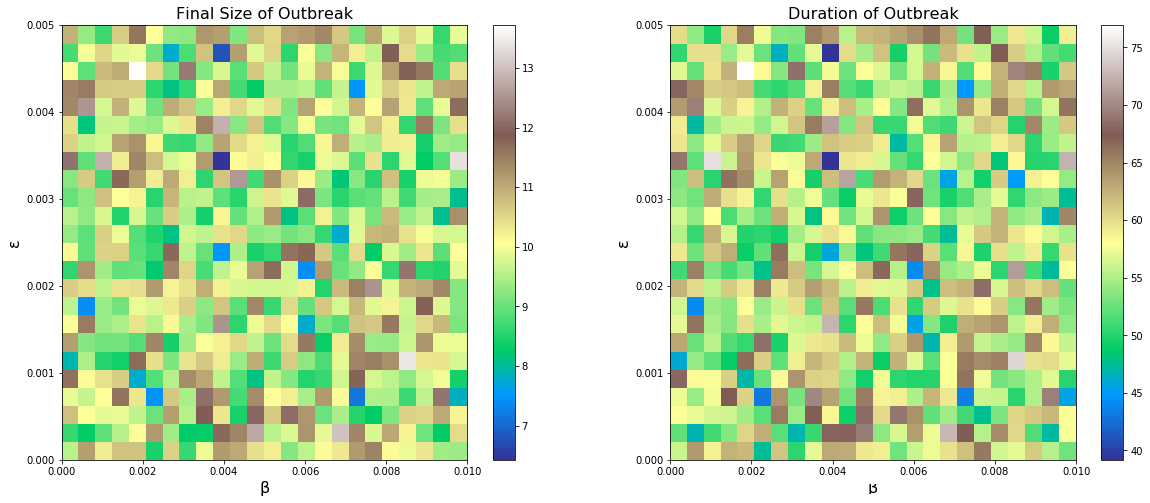

In [117]:
# sns.heatmap(final, cmap='terrain')
fig, ax = plt.subplots(figsize=(20,8))
plt.subplot(1,2,1)
pcm = plt.pcolormesh(betas, eps, final, rasterized=True, cmap= 'terrain') # you don't need rasterized=True
fig.colorbar(pcm)
plt.title('Final Size of Outbreak', fontsize = 16)
plt.ylabel('ɛ', fontsize = 16)
plt.xlabel('β', fontsize = 16)

plt.subplot(1,2,2)
pcm = plt.pcolormesh(betas, eps, duration, rasterized=True, cmap= 'terrain') # you don't need rasterized=True
fig.colorbar(pcm)
plt.title('Duration of Outbreak', fontsize = 16)
plt.ylabel('ɛ', fontsize = 16)
plt.xlabel('β', fontsize = 16)
# plt.xticks(betas, betas)
# plt.yticks(eps, eps)
plt.show()

In [87]:
X = []
betas = np.linspace(0,0.01, 25)
eps = np.linspace(0,0.005, 25)
Y = []
Z = []
Z2 = []
for i in range(len(betas)):
    for j in range(len(eps)):
        X.append(betas[i])
        Y.append(eps[j])
        Z.append(final[i,j])
        Z2.append(duration[i,j])
Z = np.array(Z)
Z2 = np.array(Z2)

In [88]:
# from mpl_toolkits.basemap import Basemap
# from mpl_toolkits.natgrid import _natgrid
eps

array([0.        , 0.00020833, 0.00041667, 0.000625  , 0.00083333,
       0.00104167, 0.00125   , 0.00145833, 0.00166667, 0.001875  ,
       0.00208333, 0.00229167, 0.0025    , 0.00270833, 0.00291667,
       0.003125  , 0.00333333, 0.00354167, 0.00375   , 0.00395833,
       0.00416667, 0.004375  , 0.00458333, 0.00479167, 0.005     ])

In [89]:

ax = fig.gca(projection='3d')
xi = np.linspace(min(X), max(X))
yi = np.linspace(min(Y), max(Y))

xx, yy = np.meshgrid(xi, yi)
zz = griddata(X, Y, Z, xi, yi,interp='linear')
z2 = griddata(X, Y, Z2, xi, yi,interp='linear')
surf = ax.plot_surface(xx, yy, zz, rstride=5, cstride=5, cmap=cm.jet,
                       linewidth=1, antialiased=True)
surf2 = ax.plot_surface(xx, yy, z2, rstride=5, cstride=5, cmap=cm.jet,
                       linewidth=1, antialiased=True)
# ax.set_zlim3d(np.min(Z), np.max(Z))
# fig.colorbar(surf)

# plt.show()

/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2.
  import sys
/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2.
  


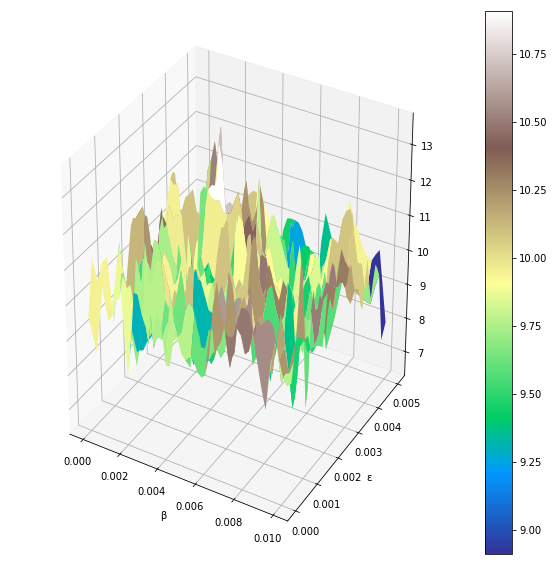

In [90]:

%matplotlib inline
fig = plt.figure(figsize =(10,10))
ax = fig.gca(projection='3d')
# plt.subplot(1,2,1)
surf = ax.plot_surface(xx, yy, zz, rstride=5, cstride=5, cmap=cm.terrain,
                       linewidth=1, antialiased=True)
ax.set_zlim3d(np.min(Z), np.max(Z))
fig.colorbar(surf)
plt.xlabel('β')
plt.ylabel('ɛ')

plt.show()

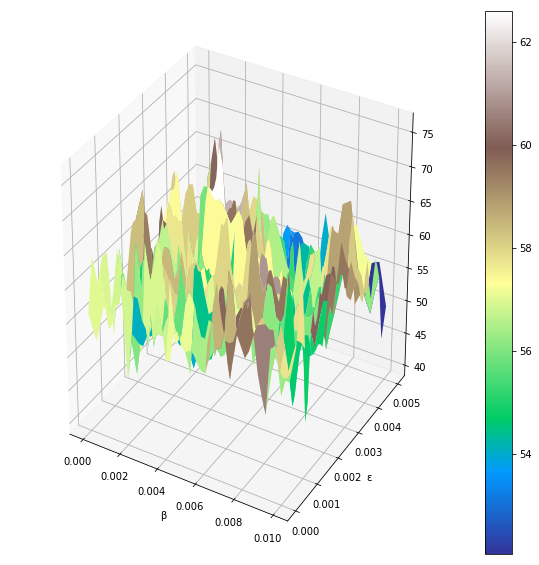

In [91]:
%matplotlib inline
fig = plt.figure(figsize =(10,10))
ax = fig.gca(projection='3d')
# plt.subplot(1,2,1)
surf = ax.plot_surface(xx, yy, z2, rstride=5, cstride=5, cmap=cm.terrain,
                       linewidth=1, antialiased=True)
ax.set_zlim3d(np.min(Z2), np.max(Z2))
fig.colorbar(surf)
plt.xlabel('β')
plt.ylabel('ɛ')

plt.show()

# Switching external environment ($\varepsilon$)

In [ ]:
β = 0.005
μ1 = 1/21 #14 days infectious
μ2 = 1/5 #5 days (14 - 9 days)
σ =1/5 #5 days exposed
ω=1/9 # 9 days until emitted to hospital
ϵ = 0.0001
α = 1/2
pp = 0.7
capT = 10000
γ = 1/(80*365)
Input_H = [1500,1,0,0,0]

In [ ]:
def gillespieSEIHR_season(initial, beta, mu1,mu2, sigma, omega,epsilon,alpha, mort, gam,  max_time):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    cuminf = []
    cuminf.append(0)
    events = []
    while times <max_time:
        state = np.zeros(shape= (5,12))
        
        ############################### Seasonality #######################################
        if times%365 <= 120:
            E = epsilon
        else:
            E = 0
        
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################    
        
        
        R_se = beta*(pop[ind][0])*(pop[ind][2] + alpha*pop[ind][3])/N + E*pop[ind][0] 
        state[:,0] = [-1, 1, 0, 0,0]
        
        R_ei = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0,0]
        
        R_ih = omega*pop[ind][2]
        state[:,2] = [0, 0, -1, 1, 0]
        
        R_ir = mort*mu1*pop[ind][2]
        state[:,3] = [0,0,-1,0,1]
        
        R_hr = mort*mu2*pop[ind][3]
        state[:,4] = [0,0,0,-1,1]

        R_is = (1-mort)*mu1*pop[ind][2]
        state[:,5] = [1,0,-1,0,0]
        
        R_hs = (1-mort)*mu2*pop[ind][3]
        state[:,6] = [1,0,0,-1,0]
        
########################## RATES ##############################
        rate = [R_se, R_ei, R_ih, R_ir, R_hr, R_is, R_hs]

        Rtotal = sum(rate)
        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        times =times+ delta_t
        event = np.min(np.where(P<=np.cumsum(rate)))
        events.append(event)
        event_time.append(times)
        pop.append(pop[ind]+state[:,event])
        
        if event == 1:
            cuminf.append(1 )
        else:
            cuminf.append(0)
        ind=ind+1
        N = sum(pop[ind][:5])

    return event_time, np.array(pop), events

In [ ]:
Gh_season = gillespieSEIHR_season(Input_H, β, μ1, μ2, σ, ω, ϵ, α,pp, γ, capT)
SEIHRt_s = Gh_season[0]
SEIHRs_s = Gh_season[1][:,0]
SEIHRe_s = Gh_season[1][:,1]
SEIHRi_s = Gh_season[1][:,2]
SEIHRh_s = Gh_season[1][:,3]
SEIHRr_s = Gh_season[1][:,4]

In [ ]:
manhes = []
manhts = []
manhhs = []
manhis = []
for ind, x in enumerate(SEIHRt_s):
    if ind<len(SEIHRt_s)-1:
        manhes.append((SEIHRe_s[ind], SEIHRe_s[ind]))
        manhhs.append((SEIHRh_s[ind], SEIHRh_s[ind]))
        manhis.append((SEIHRi_s[ind], SEIHRi_s[ind]))
        manhts.append((SEIHRt_s[ind], SEIHRt_s[ind+1]))
manhes = np.array(manhes).flatten()
manhts = np.array(manhts).flatten()
manhhs = np.array(manhhs).flatten()
manhis = np.array(manhis).flatten()

In [ ]:
plt.figure(figsize = (20,8))
# plt.plot(SEIHRt, SEIHRr/Nn,c='blue', label = 'removed')
plt.plot(manht, manhe/Nn,c='orange', label = 'exposed')
plt.plot(manht, manhh/Nn,c='magenta', label = 'hosptial')

# plt.plot(SEIHRt,SEIHRs/Nn, c='yellowgreen',label = 'susceptible')
plt.plot(manht,manhi/Nn,c= 'r', label = 'infected')
plt.legend(fontsize = 20)

# SEIHR --- variation in parameters

In [11]:
β = 0.005
ϵ = 0.0001
α = 1/2
capT = 10000
Input_H = [1500,1,0,0,0]

# μ1 = 1/np.mean(np.random.gamma(25, 0.765,1000)) #mean 19 days 
# μ2 = 1/np.mean(np.random.gamma(6, 0.8,1000)) #5 days (14 - 9 days)
# σ =1/np.mean(np.random.gamma(5,1,1000)) #5 days exposed
# ω=1/np.mean(np.random.gamma(15, 0.6,1000)) # 9 days until emitted to hospital
# ϵ = 0.0001
# α = 1/2
# pp = np.mean(np.random.beta(7,3,1000))


In [13]:
def gillespieSEIHR_adj(initial, beta, epsilon,alpha,  max_time):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    cuminf = []
    cuminf.append(0)
    events = []
    while times <max_time and (pop[ind][1]+pop[ind][2]+pop[ind][3]>0):
        state = np.zeros(shape= (5,12))
        
        mu1 = 1/np.random.gamma(25, 0.765)
        mu2 = 1/np.random.gamma(6, 0.8)
        sigma = 1/np.random.gamma(5,1)
        omega = 1/np.random.gamma(15, 0.6)
        mort = np.random.beta(7,3)
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################
        
        
        R_se = beta*(pop[ind][0])*(pop[ind][2] + alpha*pop[ind][3])/N + epsilon*pop[ind][0] 
        state[:,0] = [-1, 1, 0, 0,0]
        
        R_ei = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0,0]
        
        R_ih = omega*pop[ind][2]
        state[:,2] = [0, 0, -1, 1, 0]
        
        R_ir = mort*mu1*pop[ind][2]
        state[:,3] = [0,0,-1,0,1]
        
        R_hr = mort*mu2*pop[ind][3]
        state[:,4] = [0,0,0,-1,1]

        R_is = (1-mort)*mu1*pop[ind][2]
        state[:,5] = [1,0,-1,0,0]

        R_hs = (1-mort)*mu2*pop[ind][3]
        state[:,6] = [1,0,0,-1,0]
#         print(1/mu1, 1/mu2, 1/sigma, 1/omega, mort)

        rate = [R_se, R_ei, R_ih, R_ir, R_hr, R_is, R_hs]

        Rtotal = sum(rate)
        delta_t= -np.log(np.random.uniform(0,1))/Rtotal

        P = np.random.uniform(0,1)*Rtotal
        times =times+ delta_t
        event = np.min(np.where(P<=np.cumsum(rate)))
        events.append(event)
        event_time.append(times)
        pop.append(pop[ind]+state[:,event])
        
        if event == 1:
            cuminf.append(1 )
        else:
            cuminf.append(0)
        ind=ind+1
        N = sum(pop[ind][:5])

    return event_time, np.array(pop), events

In [14]:
def dSEIHR_dt(X, tt ):
#     print(sum(X[:3]))
    return [-β*X[0]*(X[2]+α*X[3])/sum(X[:3]) - ϵ*X[0] + (1-pp)*(μ1*X[2] + μ2*X[3]), 
            β*X[0]*(X[2]+α*X[3])/sum(X[:3]) + ϵ*X[0]- σ*X[1] ,
            σ*X[1] - (μ1+ω)*X[2],
            ω*X[2]-μ2*X[3],
            pp*(μ1*X[2]+μ2*X[3])]

ts = np.linspace(0, capT, 1000)
Nn = sum(Input_H)
P_seihr = odeint(dSEIHR_dt, Input_H, ts)

In [63]:
Gh_adj = gillespieSEIHR_adj(Input_H, β, ϵ, α, capT)
SEIHRt_adj = Gh_adj[0]
SEIHRs_adj = Gh_adj[1][:,0]
SEIHRe_adj = Gh_adj[1][:,1]
SEIHRi_adj = Gh_adj[1][:,2]
SEIHRh_adj = Gh_adj[1][:,3]
SEIHRr_adj = Gh_adj[1][:,4]

In [64]:
# manhe = [SEIHRe_adj[0]]
# manht = [SEIHRt_adj[0]]
# manhh = [SEIHRh_adj[0]]
# manhi = [SEIHRi_adj[0]]
manhe = []
manht = []
manhh = []
manhi = []
for ind, x in enumerate(SEIHRt_adj):
    if ind<len(SEIHRt_adj)-1:
        manhe.append((SEIHRe_adj[ind], SEIHRe_adj[ind]))
        manhh.append((SEIHRh_adj[ind], SEIHRh_adj[ind]))
        manhi.append((SEIHRi_adj[ind], SEIHRi_adj[ind]))
        manht.append((SEIHRt_adj[ind], SEIHRt_adj[ind+1]))

In [66]:
manhe = np.array(manhe).flatten()
manht = np.array(manht).flatten()
manhh = np.array(manhh).flatten()
manhi = np.array(manhi).flatten()

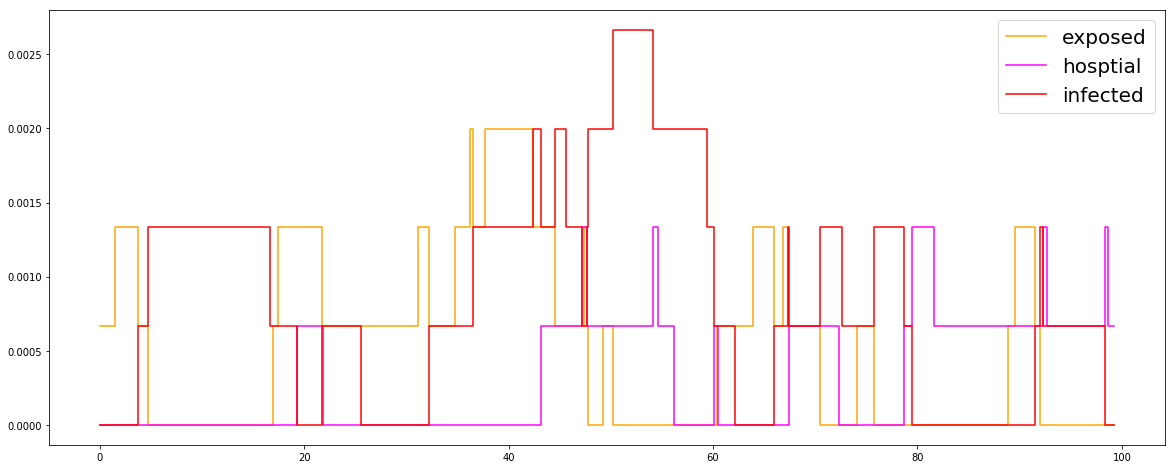

In [67]:
plt.figure(figsize = (20,8))
# plt.plot(SEIHRt, SEIHRr/Nn,c='blue', label = 'removed')
plt.plot(manht, manhe/Nn,c='orange', label = 'exposed')
plt.plot(manht, manhh/Nn,c='magenta', label = 'hosptial')

# plt.plot(SEIHRt,SEIHRs/Nn, c='yellowgreen',label = 'susceptible')
plt.plot(manht,manhi/Nn,c= 'r', label = 'infected')
plt.legend(fontsize = 20)


array([ 0.        ,  1.51677169,  1.51677169,  2.54554497,  2.54554497,
        3.69159289,  3.69159289,  4.71755647,  4.71755647,  7.53175824,
        7.53175824,  8.65357837,  8.65357837, 13.47787775])

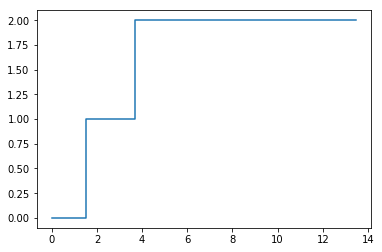

In [149]:
total_inf = []
cum_t = []
for ind, x in enumerate(SEIHRt_adj):
    if ind<len(SEIHRt_adj)-1:
        cum_t.append((SEIHRt_adj[ind], SEIHRt_adj[ind+1]))
        total_inf.append((np.cumsum(np.array(Gh_adj[2]) == 1)[ind], np.cumsum(np.array(Gh_adj[2]) == 1)[ind])) 
# np.cumsum(np.array(Gh_adj[2]) == 1)
plt.plot(np.array(cum_t).flatten(), np.array(total_inf).flatten())
total_inf
np.array(cum_t).flatten()

In [3]:
Time = []
Inf = []
Exp = []
Hos = []
N = 100
for i in range(N):
    Gh_adj = gillespieSEIHR_adj(Input_H, β, ϵ, α, capT)
    SEIHRt_adj = Gh_adj[0]
    SEIHRs_adj = Gh_adj[1][:,0]
    SEIHRe_adj = Gh_adj[1][:,1]
    SEIHRi_adj = Gh_adj[1][:,2]
    SEIHRh_adj = Gh_adj[1][:,3]
    SEIHRr_adj = Gh_adj[1][:,4]
    manhe = []
    manht = []
    manhh = []
    manhi = []
    for ind, x in enumerate(SEIHRt_adj):
        if ind<len(SEIHRt_adj)-1:
            manhe.append((SEIHRe_adj[ind], SEIHRe_adj[ind]))
            manhh.append((SEIHRh_adj[ind], SEIHRh_adj[ind]))
            manhi.append((SEIHRi_adj[ind], SEIHRi_adj[ind]))
            manht.append((SEIHRt_adj[ind], SEIHRt_adj[ind+1]))
    Time.append(manht)
    Inf.append(manhi)
    Exp.append(manhe)
    Hos.append(manhh)

NameError: name 'gillespieSEIHR_adj' is not defined